In [1]:
import numpy as np
import numpy.matlib
import pickle
import matplotlib.pyplot as plt
import scipy.linalg as sl
import time
import pathlib
import nbimporter  # I installed it for importing an .ipynb file into another .ipynb like the pilot_assignemnt

import pilot_assignment
import APLocation_Generation
import functionRlocalscattering
#------------------------------
#import Power_optimizers

import os

from datetime import datetime

from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import numpy.linalg as l 


import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
import time
import numpy.linalg as nl 


import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as Kr
from tensorflow.keras import initializers

import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score


from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


from __future__ import print_function
import keras
import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras import initializers

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils 

import time

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import mnist

In [4]:
K = 40
Ke = K
pmax = 1 #(in watt), in the next block, we have Pmax = 1000 mw
T = 1 # FL iterations


epsilon = 0.01#0.01
vareps = epsilon*np.ones([K,1])

# Number of APs:
L = 16
M = 4# CAREFUL: in my paper it is N.. !! this is M in the other codes!!


#Select length of pilot of UEs
tau_p = min(K,10) #Orthogonal sequences if tau_p=K, else tau_p = 10

#Select length of coherence block
tau_c = 200
prelogFactor = (tau_c-tau_p)/(tau_c)
preLogFactor = (tau_c-tau_p)/(tau_c)
#Number of AP antennas 


#Select the number of setups with random UE locations
nbrOfSetups = 2000

#Select the number of channel realizations per setup
nbrOfRealizations = 1# 100

## Model parameters

#Set the length in meters of the total square area
squareLength = 1000

#Number of APs per dimension
nbrAPsPerDim = np.round(np.int64(np.sqrt(L)))

#Pathloss exponent
alpha = 3.67 # or 3.76

#Average channel gain in dB at a reference distance of 1 meter.
constantTerm = -30.5

#Standard deviation of shadow fading
sigma_sf = 4  #here: put 4

#Define the antenna spacing (in number of wavelengths)
antennaSpacing = 1/2 #Half wavelength distance

#Distance between APs in vertical/horizontal direction
interAPDistance = np.int64(squareLength/nbrAPsPerDim)



## Propagation parameters

#Communication bandwidth
B = 20e6
P_u = 0.1 # watt: uplink transmit power


#Maximum downlink transmit power per AP (mW)
Pmax = 1000

#Compute downlink power per UE in case of equal power allocation
#rhoEqual = (Pmax/K)*np.ones((K,L))
rhoEqual = (pmax/K)*np.ones((K,L))
#Square roots of power coefficients for equal power allocation
gammaEqual = np.sqrt(rhoEqual)   

#Prepare power coefficients for the benchmark in [12]
rho_Giovanni19 = np.zeros((K,L,nbrOfSetups)) 

#Vertical distance between APs and UEs
distanceVertical = 10

#Define noise figure at AP (in dB)
noiseFigure = 7 ## it is 9 in paper eq(27)

#Compute noise power
noiseVariancedBm = -174 + 10*np.log10(B) + noiseFigure

#Angular standard deviation in the local scattering model (in degrees)
ASDdeg = 10

#Store identity matrix of size M x M
eyeM = np.identity(M)


# L = 3 not working, for the following function, L should be 4, 16, 25, ... otherwise it has an error!
def RandomAPLocations(L,squareLength):
    
    #Number of APs per dimension
    nbrAPsPerDim = np.round(np.int64(np.sqrt(L)))
    
    #Distance between APs in vertical/horizontal direction
    interAPDistance = np.int64(squareLength/nbrAPsPerDim)
    
    #Deploy APs on the grid
    locationsGridHorizontal = np.matlib.repmat(np.linspace(interAPDistance/2,squareLength-interAPDistance/2,nbrAPsPerDim),nbrAPsPerDim, 1)
    locationsGridVertical = np.conj(np.transpose(locationsGridHorizontal))
    APpositions = locationsGridHorizontal.reshape((L,1),order='F') + 1j*locationsGridVertical.reshape((L,1),order='F')
        
    #Randomness introduced in AP locations
    sensitivity = 0.5 # 0 means no movement, 1 means max distance is interAPDistance
    min_distance = interAPDistance * (1 - sensitivity)
    assert interAPDistance >= min_distance
#    print('Min distance between APs: ', min_distance)
    
    max_movement = (interAPDistance - min_distance)/2
    perturbation = np.random.uniform(
    low=-max_movement,
    high=max_movement,
    size=(len(APpositions), 2))
    perturbationXY = perturbation[:,0].reshape((L,1),order='F') + 1j*perturbation[:,1].reshape((L,1),order='F')
    APpositions += perturbationXY
    
    return (APpositions)




APpositions = RandomAPLocations(L,squareLength)
print(APpositions.shape)
APXpositions = APpositions.real
APYpositions = APpositions.imag




#Go through each random setup
#------------------------------------------------------------------------------------
for n in range(0, nbrOfSetups):
    #Output simulation progress
    print(n, 'setups out of', nbrOfSetups)
    
    UEpositions = np.zeros((K,1), dtype = 'complex')
    distances = np.zeros((K,L))
    
    #Prepare to store normalized spatial correlation matrices
    R = np.zeros((M,M,K,L), dtype = 'complex')
    
    #Prepare to store average channel gain numbers (in dB)
    channelGaindB = np.zeros((K,L))
    #Generate random UE locations together
    posXY = np.random.uniform(
            low = 0,
            high = squareLength,
            size = (K,2))
    UEXpositions = posXY[:,0:1]
    UEYpositions = posXY[:,1:2]
    UEpositions = UEXpositions + 1j*UEYpositions
    start = time.perf_counter()
    angletoUE = np.zeros((K,L))    
      
    for k in range(0,K):
        Xdist = np.matlib.repmat(UEXpositions[k,0], L, 1) - APXpositions
        Xdistabs = np.abs(Xdist)
        temp = np.asarray(Xdistabs > squareLength/2).nonzero()[0]
        Xdist[temp,0] = (squareLength - Xdistabs[temp,0]) * np.sign(-Xdist[temp,0])
        Ydist = np.matlib.repmat(UEYpositions[k,0], L, 1) - APYpositions
        Ydistabs = np.abs(Ydist)
        temp = np.asarray(Ydistabs > squareLength/2).nonzero()[0]
        Ydist[temp,0] = (squareLength - Ydistabs[temp,0]) * np.sign(-Ydist[temp,0])
        distances[k,:] = np.sqrt( distanceVertical**2 + Xdist[:,0]**2 + Ydist[:,0]**2)
        channelGaindB[k,:] = constantTerm - alpha*10*np.log10(distances[k,:])
        
        #Go through all APs
        for j in range(0,L):
            #Compute nominal angle between the new UE k and AP l
            angletoUE[k,j] = np.angle(Xdist[j] + 1j*Ydist[j])
            
            
           
                    
           ### R[:,:,k,j] = functionRlocalscattering.R(M,angletoUE[k,j],ASDdeg) #here % R = I*sqrt(beta)
           
    
    end = time.perf_counter() - start
    print('\n Time: ', end)
    #Generate random perturbations (shadowing) truncated at 3 dB
    for k1 in range(0,K):
        perturbation = sigma_sf*np.random.randn(1,L)
        # bool1 = np.logical_or(perturbation > 3, perturbation < -3)
        # while np.sum(bool1) != 0:
        #     perturbation[bool1] = sigma_sf*np.random.randn(1,np.sum(bool1)).reshape(np.sum(bool1))
        #     bool1 = np.logical_or(perturbation > 3, perturbation < -3)
            
        channelGainPerturbed = channelGaindB[k1,:] + perturbation
        channelGaindB[k1,:] = channelGainPerturbed
    
    channelGainOverNoise = channelGaindB - noiseVariancedBm
    g = np.zeros((M,nbrOfRealizations,K,L), dtype = 'complex')
    CH = np.sqrt(0.5)*( np.random.randn(M,nbrOfRealizations,K,L)+1j*np.random.randn(M,nbrOfRealizations,K,L) )
    betas = np.zeros((K,L))
    CorrR = np.zeros((M,M,K,L), dtype = 'complex')
    
    for j2 in range(0,L):
        for k2 in range(0,K):
            betas[k2,j2] = (10**(channelGainOverNoise[k2,j2]/10))
            
           ## CorrR[:,:,k2,j2] = betas[k2,j2] * R[:,:,k2,j2]
           ## Rsqrt = sl.sqrtm(CorrR[:,:,k2,j2])
           ## g[:,:,k2,j2] = np.matmul(Rsqrt,CH[:,:,k2,j2])
            ## this we need: g[:,:,k2,j2] = sqrt(betas)*CH
        g = CH*np.sqrt(betas)
            #np.identity(M)
            
            
            
#p_noise_dbm = -1
p_noise_dbm = -94 
rho_u = P_u /(10**(0.1*(p_noise_dbm - 30)))

rho_p = rho_u
p_p = tau_p * rho_p #my notation in paper

#p_noise_dbm = -94          
#rho_u = P_u /(10**(0.1*(p_noise_dbm - 30)))
#print(rho_u)


print(CH.shape)
print(betas.shape)

print((CH*np.sqrt(betas)).shape)
print(M)
print(K)
print(L)
print(betas.shape)

#Pilot assignment
pilotIndex = pilot_assignment.assign_pilots(K, tau_p, betas)
# for me:
print(pilotIndex)

#Generate realizations of normalized noise
Np = np.sqrt(0.5)*(np.random.randn(M,nbrOfRealizations,L,tau_p) + 1j*np.random.randn(M,nbrOfRealizations,L,tau_p))
print(Np.shape)
print(g.shape)
print(p_p)


#----------------------------------------

# Here, we do not have any summation over m=1,..,M (in paper it is n=1,..,N)
pilot_contamination = np.zeros([K,K])
for i in range(K):
    for j in range(K):
        if pilotIndex[i] == pilotIndex[j]:
            pilot_contamination[i][j] = 1
#print(pilot_contamination)
#beta_pilot_contamination = np.matmul(pilot_contamination, betas)

ckl = np.zeros([K,L]) # the same dimention as betas
ckl_denom = np.zeros([K,L])
gamma_kl = np.zeros([K,L])
beta_divies = np.zeros([K,K,L])


for l in range(L):
    for k in range(K):
        for k_prime in range(K):
            ckl_denom[k,l] += betas[k_prime,l]*pilot_contamination[k_prime,k]
            beta_divies[k,k_prime,l] = betas[k_prime,l]/betas[k,l]
        
        ckl[k,l] = np.sqrt(p_p)*betas[k,l]/(p_p*ckl_denom[k,l] + 1)
        gamma_kl[k,l] = np.sqrt(p_p)*betas[k,l]*ckl[k,l]
        
        
#gamma_kl = M* gamma_kl   
I_Lk = np.zeros([K,1])
I_Lk = M*((np.sum(gamma_kl, axis=1)).reshape(K,1))/rho_u 

##--------------------------- Compute R_j or R_k --------------------------------------###
# R_k = B log2(1 + p_k (sum_{l=1}^L  M * gamma_kl[k,l])**2 / (p_k * (sum_{l=1}^L  M * gamma_kl[k,l]*betas[k,l]) + I_pk + I_Mk ))
# I_Lk =  (sum_{l=1}^L  M * gamma_kl[k,l]/rho_u
# I_pk =  sum_{k' \neq k}^K p_k' * pilot_contamination(k,k') * (sum_{l=1}^L  M * gamma_kl[k,l]* betas[k',l]/betas[k,l] ) **2  

p = np.ones([K,1]) # users uplink powers

R_k = np.zeros([K,1])

I_pk = np.zeros([K,1])  # multiplied with p_k'

b_k_prime = np.zeros([K,K])
bk_k_prime = np.zeros([K,1]) 
    
I_pk_test = np.zeros([K,K])  # without p_k'
I_pk_test1 = np.zeros([K,K]) # without p_k'
#print(gamma_kl)
for k in range(K):
    for k_prime in range(K):
        for l in range(L):
            I_pk_test[k,k_prime] += M*gamma_kl[k,l]*beta_divies[k,k_prime,l]
        
        I_pk_test1[k,k_prime] = pilot_contamination[k_prime,k] * (I_pk_test[k,k_prime])**2
        if(k_prime ==k):
            I_pk_test1[k,k_prime] = 0
##I_Lk = np.zeros([K,1])
#----------------- My defined parameters--------------------------

#######################################################
k_per_ap = 4  # ajuste conforme sua meta de carga
served_by_ap = np.zeros((K, L), dtype=bool)

for l in range(L):
    col = gamma_kl[:, l]                 # métrica S[k,l] (pode trocar por betas[:,l], PF, etc.)
    idx = np.argpartition(col, -k_per_ap)[-k_per_ap:]
    served_by_ap[idx, l] = True
#########################################################

a = np.zeros([K,1])
b = np.zeros([K,1])

#a = (M*((np.sum(gamma_kl, axis=1)).reshape(K,1)))**2
#b = (M*((np.sum(betas*gamma_kl, axis=1)).reshape(K,1)))

a = (M*((np.sum(gamma_kl * served_by_ap, axis=1)).reshape(K,1)))**2
b = (M*((np.sum(betas * gamma_kl * served_by_ap, axis=1)).reshape(K,1)))


for k in range(K):
    for k_prime in range(K):
        for l in range(L):
            b_k_prime[k,k_prime] += M * gamma_kl[k,l] * betas[k_prime,l]
            
        if(k_prime ==k):
            b_k_prime[k,k_prime] = 0
            

#----------------------------------------------------------------- 
##bd_Ciraf10 = 32 * 3072 # bits

E = np.zeros([K,1])
ell = np.zeros([K,1])
nu = np.zeros([K,1]) 
#----------------------------------------------------------------
for k in range(K):
    for k_prime in range(K):
        I_pk[k] += p[k_prime] * I_pk_test1[k,k_prime]
        bk_k_prime [k] += p[k_prime] * b_k_prime[k,k_prime]
    
    R_k[k] = B * np.log2(1 + a[k] * p[k]/(b[k] * p[k] + bk_k_prime [k]  + I_pk[k]  + I_Lk[k]))
    E[k] = p[k]/R_k[k]
    ell[k] = 1/R_k[k] 
   # nu[k] = theta * E[k] + (1-theta)* ell[k]
    
#----------------------- Rate: ------------------------------            
def Rate_k(a, b, B, p, K, I_Lk, I_pk_test1, b_k_prime, preLogFactor):
    Rate = np.zeros([K,1])
    bk_k_prime = np.zeros([K,1])
    I_pk = np.zeros([K,1])
    
    for k in range(K):
        for k_prime in range(K):
            I_pk[k] += p[k_prime] * I_pk_test1[k,k_prime]
            bk_k_prime [k] += p[k_prime] * b_k_prime[k,k_prime]
    
        Rate[k] = preLogFactor*B * np.log2(1 + a[k] * p[k]/(b[k] * p[k] + bk_k_prime [k]  + I_pk[k]  + I_Lk[k]))
    return Rate


#------------ Power allocation:----------------------


def power_allocation_original(a, b, B, p0, K, I_Lk, I_pk_test1, b_k_prime, eps, theta_1, theta_2, rho_u, P_u, preLogFactor):
    p00 = p0
    p = p0
    powers = np.zeros([K,1])
    TT = 1000
    p1 = np.linspace(0.000001, 1, TT)
    for k in range(K):
        #
        R_k_TT = np.zeros([TT,1])
        E_TT = np.zeros([TT,1])
        ell_TT = np.zeros([TT,1])
        nu_TT = np.zeros([TT,1])
        NU = np.zeros([TT,K])
        #p = 1*np.ones([K,1]) #0.1*np.random.rand(K,1)#

        for t in range(TT):
            test = k
            E = 0
            ell = 0
            R_k_test = np.zeros([K,1])
            p[test] = p1[t]
    
            R_k_test = preLogFactor*Rate_k(a, b, B, p, K, I_Lk, I_pk_test1, b_k_prime)
            R_k_TT[t] =  R_k_test[test]
    
            for kk in range(K):
                ell += 1/ R_k_test[kk]
                E += P_u*p[kk] / R_k_test[kk]
        
        
    
            ell_TT[t] = ell
            E_TT[t] = E
            nu_TT[t] = theta_1 * E_TT[t] + theta_2 *  ell_TT[t]
            NU[t,test] = nu_TT[t]
        #min(nu_TT)
        ff=np.where(nu_TT == min(nu_TT))
        ff0 = ff[0].astype('int64')
        p[k] = p1[ff0]#p1[max(ff0,0)]

        p0 = p00
   
    return p, p0
#---------------------------parameters I_pk_test1, I_pk --------------------

def parameters(P, a, b, K, M, L, gamma_kl, rho_u, beta_divies, pilot_contamination, betas):
    R_k = np.zeros([K,1])
    I_Lk = np.zeros([K,1])
    I_pk = np.zeros([K,1])  # multiplied with p_k'
    I_Lk = M*((np.sum(gamma_kl, axis=1)).reshape(K,1))/rho_u 
    b_k_prime = np.zeros([K,K])
    bk_k_prime = np.zeros([K,1]) 
    
    I_pk_test = np.zeros([K,K])  # without p_k'
    I_pk_test1 = np.zeros([K,K]) # without p_k'


   
    for k in range(K):
        for k_prime in range(K):
            for l in range(L):
                I_pk_test[k,k_prime] += M*gamma_kl[k,l]*beta_divies[k,k_prime,l]
        
            I_pk_test1[k,k_prime] = pilot_contamination[k_prime,k] * (I_pk_test[k,k_prime])**2
            if(k_prime ==k):
                I_pk_test1[k,k_prime] = 0
            

    for k in range(K):
        for k_prime in range(K):
            I_pk[k] += p[k_prime] * I_pk_test1[k,k_prime]
            bk_k_prime [k] += p[k_prime] * b_k_prime[k,k_prime]            

    return I_pk_test1, I_pk               
#---------------------------------------------------------------
#b_k_prime[k_prime,j] += M * gamma_kl[k_prime,l] * betas[j,l]
#I_pk_test1[k_prime,j] = pilot_contamination[j,k_prime] * (I_pk_test[k_prime,j])**2
#B_tilde_k'^j =  b_k_prime[k_prime,j] + I_pk_test1[k_prime,j]

b_tilde_prime = b_k_prime + I_pk_test1

def p_j_gradient(a, b, K, j, M, p, b_k_prime, b_tilde_prime, I_Lk, I_pk, theta1, theta2, gamma_kl, betas, beta_divies, pilot_contamination):
    
    ln2 = np.log(2)
    C_j = 0
    L_j = 0
    C = np.zeros([K,1])
    C_tilde = np.zeros([K,1])
    C_temp = np.zeros([K,1])
    L_tilde = np.zeros([K,1])
    
 
    for j_prime in [x for x in range(K) if x != j]:
        c = 0
        for l in range(L):
            c += M* gamma_kl[j, l] * betas[j_prime, l]
        
        C[j_prime] = np.copy(c) * p[j_prime]
        
    C_j = I_pk[j] + I_Lk[j] + np.sum(C)
    
    L_j = a[j] * C_j /( ((a[j]+b[j])*p[j] + C_j) * (b[j]*p[j] + C_j) * ln2 )
    
   
    for k_prim in [x for x in range(K) if x != j]:
        
        for j_prim0 in [y for y in range(K) if y != k_prim]:
        
            c = 0
            for l in range(L):
                c += M* gamma_kl[k_prim, l] * betas[j_prim0, l]
            
            C_temp[k_prim] += p[j_prim0]* np.copy(c)
    
        C_tilde[k_prim] = b[k_prim]*p[k_prim] + I_pk[k_prim] + I_Lk[k_prim] -p[j]* b_tilde_prime[k_prim,j]  + C_temp[k_prim]
    
   
    for k_prim0 in [x for x in range(K) if x != j]:
        
        L_tilde[k_prim0] = - b_tilde_prime[k_prim0 , j] * a[k_prim0] * p[k_prim0] /( ln2*(b_tilde_prime[k_prim0 , j] * p[k_prim0] + C_tilde[k_prim0] )*( (a[k_prim0]+b_tilde_prime[k_prim0 , j]) * p[k_prim0] + C_tilde[k_prim0] ))
    
   
    return C_j, L_j, C_tilde, L_tilde


#========================= Partial_nu_j===========================================

def Partial_nu_j(j, p, P_u, theta_1, theta_2, a, b, K, M, L, b_tilde_prime, C_j, L_j, C_tilde, L_tilde ):
    
    ln2 = np.log(2)
    
    partial_nu_j = 0
    
    term_j = 0
    
    term_non_j = 0
    
    term_j = (theta_1*P_u)/(np.log2( 1 + p[j]*a[j]/( p[j]*a[j] + C_j ))) - (theta_1*P_u*p[j] + theta_2)*L_j/(np.log2( 1 + p[j]*a[j]/( p[j]*a[j] + C_j )))**2
  
   
    
    for k_prim in [x for x in range(K) if x != j]:
       
        term_non_j += (theta_1*P_u*p[k_prim] + theta_2)*L_tilde[k_prim] /(np.log2( 1 + p[k_prim]*a[k_prim]/( p[j]*b_tilde_prime[k_prim, j] + C_tilde[k_prim] )))**2
        

    
    partial_nu_j = term_j - term_non_j

    return partial_nu_j


#------------------------------generalized Dinkelbach-----------------------

# The following code is the generalized Dinkelbach

def objective_function_CFmMIMO(p, a, b, I_Lk, I_pk_test1, b_k_prime, zeta, Lambda, P_u):
    K = len(p)
    d = I_pk_test1 + b_k_prime
    c = I_Lk
    f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]
    g_values = [zeta[0] * P_u*p[j] + zeta[1] for j in range(K)]
    h_values = [f_values[j] - Lambda * g_values[j] for j in range(K)]
    return -np.min(h_values)


def update_lambda_CFmMIMO(p, a, b, I_Lk, I_pk_test1, b_k_prime, zeta, P_u):
    K = len(p)
    d = I_pk_test1 + b_k_prime
    c = I_Lk
    f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]
    g_values = [zeta[0] *P_u* p[j] + zeta[1] for j in range(K)]
    lambda_values = [f_values[j] / g_values[j] for j in range(K)]
    return np.min(lambda_values)

def find_optimal_p_generalized_Dinkelbach_CFmMIMO(a, b, I_Lk, I_pk_test1, b_k_prime, zeta, P_u, epsilon=1e-8):
    K = len(a)
    Lambda = 0
    #p = np.full(K, 0.5)  # Initialize with a constant value, you can also use np.random.rand(K) for a uniform distribution

    #p = p_main_EE + 0.0001#
    p = 0.25* np.ones(K)#
    bounds = [[0, 1] for _ in range(K)]
    while True:
        # Solve the optimization problem
        result = minimize(lambda p: objective_function_CFmMIMO(p, a, b, I_Lk, I_pk_test1, b_k_prime, zeta, Lambda, P_u), 
                          p, bounds=bounds, method='SLSQP')
        #result = minimize(lambda p: objective_function_CFmMIMO(p, a, b, I_Lk, I_pk_test1, b_k_prime, zeta, Lambda, P_u),
        #                  p, bounds=bounds, method='Powell',
        #                  options={'ftol': epsilon, 'L-BFGS-B': False})
        # Update p
        p = result.x

        # Update Lambda
        Lambda = update_lambda_CFmMIMO(p, a, b, I_Lk, I_pk_test1, b_k_prime, zeta, P_u)

        # Calculate F
        d = I_pk_test1 + b_k_prime
        c = I_Lk
        f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]
        g_values = [zeta[0] *P_u* p[j] + zeta[1] for j in range(K)]
        F = np.min([f_values[j] - Lambda * g_values[j] for j in range(K)])

        # Check for convergence
        if np.abs(F) < epsilon:
            break

    return np.clip(p, 0, 1), Lambda, F  # Clip values to ensure they are within [0, 1]





#-----------------Parameters for theta computations-------------------------------------

# A = \bar{A} is vector K-by-1
# B = \bar{B} is vector K-by-1
# B_prime = the matrix of all B_prime_kk' K-by_K
# I_M is vector vector K-by_1


A_bar = a
B_bar = b
#I_M = M*((np.sum(gamma_kl, axis=1)).reshape(K,1))/rho_u # I_Lk
I_M = M*((np.sum(gamma_kl * served_by_ap, axis=1)).reshape(K,1))/rho_u # I_Lk
    
B_prime = np.zeros([K,K])

B_prime0 = np.zeros([K,K])
B_prime1 = np.zeros([K,K])

for j in range(K):
  
    for k in [x for x in range(K) if x != j]:
        ######################
        Lk = np.where(served_by_ap[k, :])[0]  # APs que realmente servem o usuário k
        ##############
        for l in Lk:
        #for l in range(L):
            B_prime0[j,k] += M * gamma_kl[k,l] * betas[j,l]
            B_prime1[j,k] += M * gamma_kl[k,l] * beta_divies[k,j,l]
            
        B_prime[j,k] = B_prime0[j,k] + pilot_contamination[j,k]*B_prime1[j,k]**2

B_tilde = B_prime        
#B_prime = I_pk_test1 + b_k_prime#np.transpose(I_pk_test1 + b_k_prime)
I_M

(16, 1)
0 setups out of 2000

 Time:  0.003782400000091002
1 setups out of 2000

 Time:  0.0036614999999073916
2 setups out of 2000

 Time:  0.0035788000004686182
3 setups out of 2000

 Time:  0.003579899999749614
4 setups out of 2000

 Time:  0.0035720000005312613
5 setups out of 2000

 Time:  0.0035619000000224332
6 setups out of 2000

 Time:  0.003565399999388319
7 setups out of 2000

 Time:  0.0035712999997485895
8 setups out of 2000

 Time:  0.0035625999998956104
9 setups out of 2000

 Time:  0.0035604000004241243
10 setups out of 2000

 Time:  0.0035623000003397465
11 setups out of 2000

 Time:  0.003568500000255881
12 setups out of 2000

 Time:  0.003585600000405975
13 setups out of 2000

 Time:  0.0035812999994959682
14 setups out of 2000

 Time:  0.0036031999998158426
15 setups out of 2000

 Time:  0.003582299999834504
16 setups out of 2000

 Time:  0.0035855999994964805
17 setups out of 2000

 Time:  0.0035692999999810127
18 setups out of 2000

 Time:  0.0035881999992852798
1

C:\Users\karen\AppData\Local\Temp\ipykernel_20380\1368960494.py:346: RuntimeWarning: divide by zero encountered in divide
  E[k] = p[k]/R_k[k]
C:\Users\karen\AppData\Local\Temp\ipykernel_20380\1368960494.py:347: RuntimeWarning: divide by zero encountered in divide
  ell[k] = 1/R_k[k]


array([[9.00491481e-12],
       [1.78666481e-12],
       [7.32339536e-10],
       [1.91294920e-12],
       [1.42300540e-12],
       [4.74130363e-13],
       [0.00000000e+00],
       [6.35886224e-13],
       [7.46428774e-12],
       [4.54460102e-12],
       [3.29970246e-12],
       [9.63510460e-12],
       [3.85003626e-12],
       [7.88111899e-13],
       [3.26117205e-13],
       [2.62885978e-13],
       [6.14185103e-12],
       [0.00000000e+00],
       [1.91067109e-12],
       [4.95086303e-12],
       [2.67661262e-11],
       [0.00000000e+00],
       [6.88215127e-13],
       [5.90030883e-13],
       [7.18126515e-11],
       [3.01073057e-13],
       [2.06848081e-12],
       [1.59018970e-12],
       [9.11334302e-12],
       [3.07858768e-12],
       [5.56472558e-12],
       [1.84098955e-11],
       [4.53856108e-09],
       [1.32246946e-12],
       [3.87948898e-13],
       [7.16153522e-13],
       [2.18752767e-12],
       [5.42756177e-12],
       [2.59933692e-13],
       [4.96639009e-12]])

In [3]:
p_dink, lambda_din, F_din = find_optimal_p_generalized_Dinkelbach_CFmMIMO(a, b, I_Lk, I_pk_test1, b_k_prime, np.array([1, 1]), P_u, epsilon=1e-8)


C:\Users\karen\AppData\Local\Temp\ipykernel_10520\3229412868.py:515: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]
C:\Users\karen\AppData\Local\Temp\ipykernel_10520\3229412868.py:525: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]
C:\Users\karen\AppData\Local\Temp\ipykernel_10520\3229412868.py:554: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin

In [4]:
p_dink

array([0.08213218, 0.05058242, 0.00551815, 0.60295485, 0.07336347,
       0.00101762, 0.06629836, 0.07435474, 0.28286182, 0.08365903,
       0.06594541, 0.01178693, 0.03773595, 0.41253721, 0.1830405 ,
       0.32548904, 0.1812772 , 0.05729459, 0.5544329 , 0.33490124,
       0.05765154, 0.02761664, 0.30096808, 0.10341556, 0.09987476,
       0.15475628, 0.02703829, 0.03529565, 0.86638156, 0.01074132,
       0.24952429, 0.05297434, 0.55675722, 0.12730241, 0.05223021,
       0.04503867, 0.04772924, 0.04616783, 0.72261098, 0.17086118])

In [5]:
import numpy as np

def uniform_quantization(x, b):
    """
    Perform uniform quantization on the non-negative input data x with b bits.

    Parameters:
    x (numpy array): Non-negative input data to be quantized
    b (int): Number of bits for quantization

    Returns:
    numpy array: Quantized data
    """
    
    x_max = np.max(np.abs(x))
    x_min = np.min(np.abs(x))
    R = x_max - x_min
    # Number of quantization levels
    L = 2 ** b

    # Quantization step size
    delta = R / (L-1)

    x_clipped = np.clip(x, x_min, x_max)  # Ensure values are within [x_min, x_max]
    quantized = np.round((x_clipped - x_min) / delta) * delta + x_min

    return quantized
#-----------------------------------------------------------------------------
def adaptive_signQuant_lambda(main_vector, dim, lambda_j, b_j):
    mynum = 0
    l_norm = np.linalg.norm(main_vector, ord=np.inf)
    
    # Normalize each element of the vector 
    normalized_x = np.abs(main_vector) / l_norm

    # Identify the indices where the normalized value is greater than or equal to lambda
    indices = np.where(normalized_x >= lambda_j)[0]
    non_indices = np.where(normalized_x < lambda_j)[0]

    # Count the number of positive and negative elements among these indices
    positive_elements = main_vector[indices] > 0
    negative_elements = main_vector[indices] < 0

    n_max = np.sum(positive_elements)
    n_min = np.sum(negative_elements)

    x = np.copy(main_vector)
    x_q = mynum*np.ones_like(x)#*np.sign(x)
    x_q_temp = np.zeros_like(x)

    # Quantize values where normalized_x >= lambda_j
    for i in indices:
        x_q_temp[i] = np.abs(x[i])
    x_q0 = uniform_quantization(x_q_temp, b_j)
    for i in indices:
        x_q[i] = np.sign(x[i]) * x_q0[i]

    if n_max > 0:
        largest_values_indices = np.argsort(x_q)[-n_max:]
        largest_values = x_q[largest_values_indices]
    else:
        largest_values_indices = np.array([], dtype=int)
        largest_values = np.array([], dtype=x_q.dtype)

    # Find the n_min smallest values and their indices
    if n_min > 0:
        smallest_values_indices = np.argsort(x_q)[:n_min]
        smallest_values = x_q[smallest_values_indices]
    else:
        smallest_values_indices = np.array([], dtype=int)
        smallest_values = np.array([], dtype=x_q.dtype)

    if largest_values.size > 0:
        x_max = np.min(largest_values)
    else:
        x_max = 0

    if smallest_values.size > 0:
        x_min = np.max(smallest_values)
    else:
        x_min = 0
    
    if np.abs(x_min) > 0 and x_max > 0:
        x_min_me = min(x_max, np.abs(x_min))
    else:
        x_min_me = max(x_max,0, np.abs(x_min))
    
    if x_min_me <  1e-10:
        x_min_me =  0.0001
    
    for i in range(len(main_vector)):
        if x_q[i] ==mynum:
            x_q[i] = (np.sign(x[i]) == 1)*x_min_me/2 - (np.sign(x[i]) == -1)*x_min_me/2
    
    x_quant = x_q
    err = main_vector - x_quant
    
    # Return the results
    return x_q, x_max, x_min, err, n_max, n_min, x_min_me 



In [6]:
# Compute each Lambda_j here: 
Y3 = np.copy(I_M)
for i in range(K):
    Y3[i]=np.sum(B_tilde[:,i])

X31 = np.log2(1+(A_bar/(B_bar + Y3 + I_M)))
#Lambda_0 = 1 - X31/np.sum(X31) #+ 0.00001
Lambda_0 = 1 - X31/np.max(X31) + 0.00001


Lambda_old =  Lambda_0/np.sum(Lambda_0)

def logarithmic_transformation(X, K):
    return np.log1p(X * (K - 1)) / np.log(K)
Lambda_new = logarithmic_transformation(Lambda_old, K)
#print('------------------------------')
#print(Lambda_new.T)
Lambda1 = Lambda_old
#/np.max(Lambda_0) )

omegaa_q = 1
#Lambda =omegaa_q*Lambda_0

print(Lambda1.T)
#Lambda = Lambda_0/np.max(Lambda_0)- 0.00001
lambda_coef = np.mean(Lambda1)
Lambda31 = 2*lambda_coef *np.ones(K)
print('-------------------------------------------')
print(Lambda31.T)

[[2.45238213e-02 7.86207168e-03 1.23488980e-03 3.83493567e-02
  3.72611829e-02 3.97383306e-07 2.89774747e-02 2.32958656e-02
  3.68856464e-02 1.82900859e-02 6.20744021e-03 2.45107571e-02
  1.57772913e-02 3.77169792e-02 3.88153169e-02 3.79020513e-02
  3.52694841e-02 3.74219260e-02 3.64459780e-02 3.57938827e-02
  7.00300034e-03 1.16601455e-02 3.35213644e-02 3.79402065e-02
  2.49987223e-02 2.58860839e-02 8.71139506e-03 1.46885441e-02
  3.96024070e-02 3.99849675e-03 3.49081404e-02 1.89368952e-02
  3.81821957e-02 3.46465274e-02 6.88489238e-03 1.50175841e-02
  1.95594024e-02 3.23708360e-02 3.75858887e-02 3.13553727e-02]]
-------------------------------------------
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]


In [7]:
Lambda = 0.2*np.ones(K)

# FL for one lambda:

In [8]:
# Load CIFAR-10 dataset NON-IID
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data
num_clients= K


#------------------------------DATASETS--------------------------------------------------
## Split the data into non-overlapping portions for each client
# Load CIFAR-10 dataset


#------------------------------DATASETS--------------------------------------------------
## Split the data into non-overlapping portions for each client
client_data = []
samples_per_client = len(x_train) // num_clients
#for i in range(num_clients):
#    start = i * samples_per_client
#    end = (i + 1) * samples_per_client
#    x_client = x_train[start:end]
#    y_client = y_train[start:end]
#    client_data.append((x_client, y_client))

# Assume x_train and y_train are numpy arrays, and num_clients is an integer
# Assume x_train and y_train are numpy arrays, and num_clients is an integer
np.random.seed(42)  # For reproducibility

# Shuffle the data to start with a random distribution
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Group data by class for controlled allocation
class_indices = {}
for label in np.unique(y_train):
    class_indices[label] = list(np.where(y_train == label)[0])  # Convert to list for easy pop operations

# Split data for each client with varying class proportions
client_data = []
num_classes = len(class_indices)
samples_per_client = len(x_train) // num_clients  # Ensures equal samples per client

for i in range(num_clients):
    x_client = []
    y_client = []

    # Determine class proportions for this client
    proportions = np.random.dirichlet(alpha=[0.4] * num_classes)

    # Track the number of samples allocated to this client
    allocated_samples = 0

    while allocated_samples < samples_per_client:
        for label in range(num_classes):
            # Calculate how many samples to take for this class based on proportions
            num_samples = int(proportions[label] * samples_per_client)

            # Adjust to ensure we fill the client's quota exactly
            if allocated_samples + num_samples > samples_per_client:
                num_samples = samples_per_client - allocated_samples

            # Ensure we don't sample more than available for the class
            num_samples = min(num_samples, len(class_indices[label]))

            # Select the samples and add them to the client's data
            class_samples = class_indices[label][:num_samples]
            x_client.extend(x_train[class_samples])
            y_client.extend(y_train[class_samples])

            # Remove used samples from class
            class_indices[label] = class_indices[label][num_samples:]

            # Update allocated sample count
            allocated_samples += len(class_samples)

            # If the client has enough samples, break the loop
            if allocated_samples >= samples_per_client:
                break

    # Shuffle the client's data to randomize order
    x_client = np.array(x_client)
    y_client = np.array(y_client)
    client_indices = np.arange(len(x_client))
    np.random.shuffle(client_indices)
    x_client = x_client[client_indices]
    y_client = y_client[client_indices]

    client_data.append((x_client, y_client))
# Plot distribution for a few clients
def plot_client_data_distribution(client_data, client_labels, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param client_labels: List of label arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data = client_data[client_id]
        labels = client_labels[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
#----------------------------------------------------------------------------------------------

# client_data now contains non-IID datasets for each client

# Display some information about the distribution
for i, (data, labels) in enumerate(client_data):
    print(f"Client {i}: {len(data)} samples")
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print(f"Label distribution: {label_distribution}\n")

# Plot distribution for a few clients
def plot_client_data_distribution(client_data, client_labels, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param client_labels: List of label arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data = client_data[client_id]
        labels = client_labels[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
#----------------------------------------------------------------------------------------------

Client 0: 1250 samples
Label distribution: {0: 22, 1: 328, 3: 249, 4: 64, 5: 7, 6: 147, 8: 194, 9: 239}

Client 1: 1250 samples
Label distribution: {0: 72, 1: 1, 3: 35, 4: 61, 5: 1, 6: 126, 7: 62, 8: 892}

Client 2: 1250 samples
Label distribution: {0: 170, 1: 241, 2: 1, 3: 31, 4: 203, 5: 191, 6: 314, 7: 7, 8: 76, 9: 16}

Client 3: 1250 samples
Label distribution: {0: 82, 1: 98, 2: 52, 3: 3, 4: 492, 5: 389, 7: 17, 8: 6, 9: 111}

Client 4: 1250 samples
Label distribution: {2: 49, 3: 1, 4: 10, 5: 116, 6: 307, 7: 13, 8: 723, 9: 31}

Client 5: 1250 samples
Label distribution: {0: 229, 1: 113, 2: 180, 3: 47, 4: 159, 6: 100, 7: 10, 8: 320, 9: 92}

Client 6: 1250 samples
Label distribution: {1: 222, 2: 207, 3: 14, 4: 3, 5: 15, 6: 500, 8: 64, 9: 225}

Client 7: 1250 samples
Label distribution: {0: 23, 1: 3, 2: 84, 3: 21, 4: 24, 5: 222, 6: 233, 7: 336, 8: 201, 9: 103}

Client 8: 1250 samples
Label distribution: {2: 290, 3: 26, 5: 324, 6: 345, 7: 143, 8: 68, 9: 54}

Client 9: 1250 samples
Label 

Client 0: 1250 samples
Label distribution: {0: 122, 1: 131, 2: 117, 3: 133, 4: 114, 5: 132, 6: 114, 7: 136, 8: 119, 9: 132}

Client 1: 1250 samples
Label distribution: {0: 125, 1: 113, 2: 139, 3: 123, 4: 135, 5: 121, 6: 122, 7: 113, 8: 136, 9: 123}

Client 2: 1250 samples
Label distribution: {0: 110, 1: 133, 2: 126, 3: 131, 4: 109, 5: 127, 6: 137, 7: 134, 8: 128, 9: 115}

Client 3: 1250 samples
Label distribution: {0: 119, 1: 110, 2: 145, 3: 136, 4: 128, 5: 124, 6: 112, 7: 126, 8: 120, 9: 130}

Client 4: 1250 samples
Label distribution: {0: 121, 1: 131, 2: 118, 3: 119, 4: 103, 5: 127, 6: 140, 7: 118, 8: 132, 9: 141}

Client 5: 1250 samples
Label distribution: {0: 124, 1: 116, 2: 124, 3: 126, 4: 115, 5: 132, 6: 124, 7: 128, 8: 136, 9: 125}

Client 6: 1250 samples
Label distribution: {0: 133, 1: 121, 2: 126, 3: 115, 4: 127, 5: 126, 6: 130, 7: 116, 8: 117, 9: 139}

Client 7: 1250 samples
Label distribution: {0: 119, 1: 124, 2: 135, 3: 140, 4: 102, 5: 126, 6: 117, 7: 123, 8: 129, 9: 135}



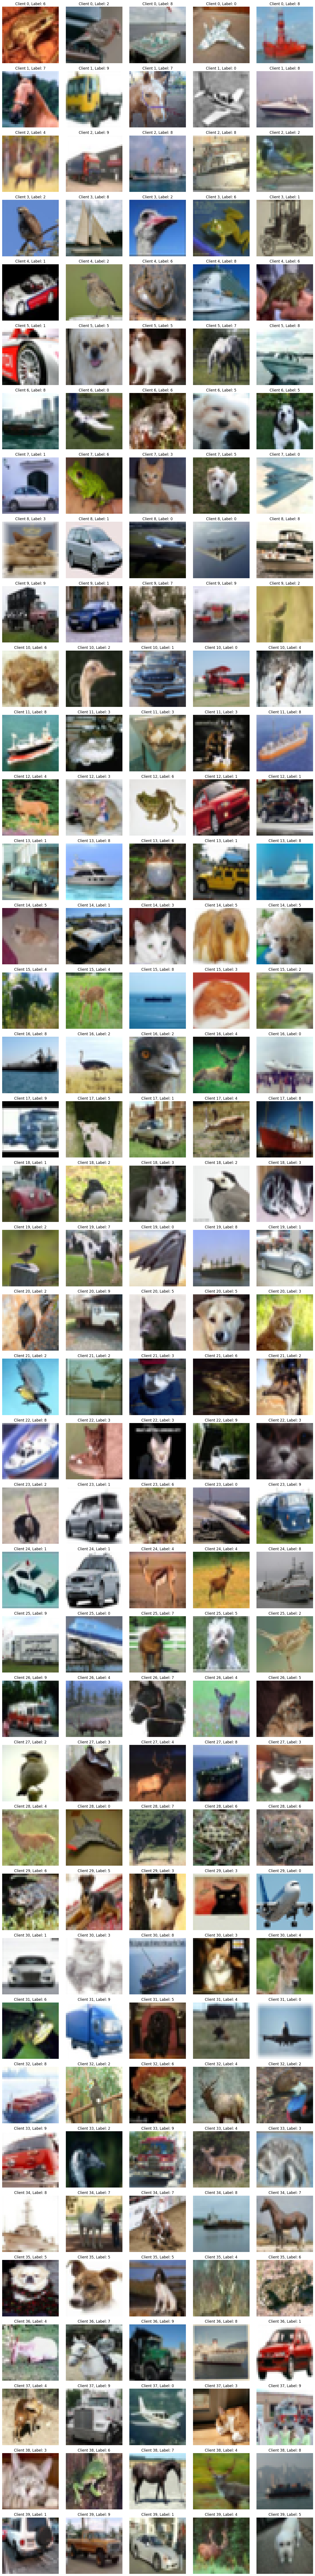

In [9]:
#IID:

num_clients= K
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data

# Number of clients


np.random.seed(42)  # For reproducibility

# Shuffle the data to start with a random distribution
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Split data into equal parts for each client
samples_per_client = len(x_train) // num_clients

# Allocate data to clients
client_data = []
for i in range(num_clients):
    start_idx = i * samples_per_client
    end_idx = (i + 1) * samples_per_client

    x_client = x_train[start_idx:end_idx]
    y_client = y_train[start_idx:end_idx]

    # Shuffle the client's data to randomize order
    client_indices = np.arange(len(x_client))
    np.random.shuffle(client_indices)
    x_client = x_client[client_indices]
    y_client = y_client[client_indices]

    client_data.append((x_client, y_client))

# Display some information about the distribution
for i, (data, labels) in enumerate(client_data):
    print(f"Client {i}: {len(data)} samples")
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique.flatten(), counts))
    print(f"Label distribution: {label_distribution}\n")

# Plot distribution for a few clients
def plot_client_data_distribution(client_data, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data, labels = client_data[client_id]
        
        for i in range(min(num_samples, len(data))):  # Ensure we don't exceed available samples
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_client_data_distribution(client_data, num_clients=num_clients)


In [10]:
# Plot the data distribution for each client
def plot_client_distribution(client_data, num_classes):
    num_clients = len(client_data)
    fig, axes = plt.subplots(nrows=1, ncols=num_clients, figsize=(15, 5), sharey=True)

    if num_clients == 1:
        axes = [axes]

    for i, (x_client, y_client) in enumerate(client_data):
        unique, counts = np.unique(y_client, return_counts=True)
        label_distribution = dict(zip(unique, counts))

        axes[i].bar(range(num_classes), [label_distribution.get(j, 0) for j in range(num_classes)], tick_label=range(num_classes))
        axes[i].set_title(f'Client {i}')
        axes[i].set_xlabel('Class Label')
        axes[i].set_ylabel('Number of Samples')
        axes[i].set_ylim(0, samples_per_client)  # Set y-limit to the number of samples per client

    plt.tight_layout()
    plt.show()

# Call the function to plot the distributions
#plot_client_distribution(client_data, num_classes)


313/313 [==============================] - 1s 2ms/step - loss: 2.3271 - accuracy: 0.1165
Initial Test Loss: 2.3271
Initial Test Accuracy: 0.1165
Global Iteration 1/30
Client 1/40


C:\Users\karen\AppData\Local\Temp\ipykernel_10520\1058551630.py:135: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights)


max: 0.45229899883270264 ----min: -0.17485807836055756
n_max: 25 n_min: 154 Lambda_j: 0.2
max error: 0.045318325535751124
max_model: 0.0910787817786283 min_model: -0.09063665176999418 x_min_me: 0.09063665176999418
percentage %: 0.038710235505287516
Client 2/40


C:\Users\karen\AppData\Local\Temp\ipykernel_10520\1058551630.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))


max: 0.4759007692337036 ----min: -0.26167523860931396
n_max: 48 n_min: 49 Lambda_j: 0.2
max error: 0.04768311622063698
max_model: 0.09815744116159479 min_model: -0.0953662343039191 x_min_me: 0.0953662343039191
percentage %: 0.020977054994485413
Client 3/40
max: 0.3592652976512909 ----min: -0.18697458505630493
n_max: 38 n_min: 113 Lambda_j: 0.2
max error: 0.03599676689431654
max_model: 0.07234472269419934 min_model: -0.07199353471995565 x_min_me: 0.07199353471995565
percentage %: 0.032655003135745334
Client 4/40
max: 0.48755908012390137 ----min: -0.25911611318588257
n_max: 53 n_min: 75 Lambda_j: 0.2
max error: 0.048851225617999906
max_model: 0.0981790523025647 min_model: -0.09770245496129011 x_min_me: 0.09770245496129011
percentage %: 0.027681062260764257
Client 5/40
max: 0.4997471272945404 ----min: -0.1871875673532486
n_max: 55 n_min: 50 Lambda_j: 0.2
max error: 0.050072414304137974
max_model: 0.10014483000525981 min_model: -0.10014483000525981 x_min_me: 0.10014483000525981
percentage 

C:\Users\karen\anaconda3\envs\new_artigo_39\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


313/313 [==============================] - 1s 2ms/step - loss: 2.2604 - accuracy: 0.1602
Global Test loss: 2.2604, Global Test accuracy: 0.1602
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 1s 2ms/step - loss: 2.2785 - accuracy: 0.1359
_FedAvg Global Test loss: 2.2785, _FedAvg Global Test accuracy: 0.1359
------------------------------------------------------------------------------------------------------
Global Iteration 2/30
Client 1/40
max: 0.4679558575153351 ----min: -0.4266112446784973
n_max: 196 n_min: 133 Lambda_j: 0.2
max error: 0.04688707225703846
max_model: 0.0937741454453995 min_model: -0.0937741454453995 x_min_me: 0.0937741454453995
percentage %: 0.07114898034212062
Client 2/40
max: 0.5421041250228882 ----min: -0.4789779782295227
n_max: 122 n_min: 92 Lambda_j: 0.2
max error: 0.05431639548060634
max_model: 0.10863279142687397 min_model: -0.10916270748261482 x_min_me: 0.1086327

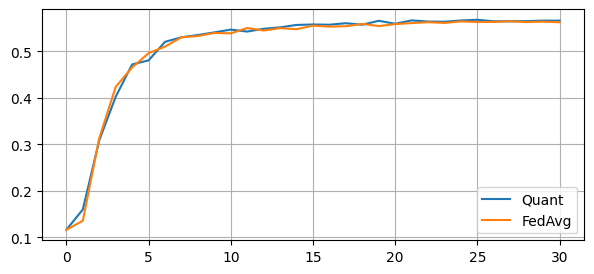

In [11]:
#Lambda = Lambda31
Lambda = 0.2*np.ones(K)
#local_epochs = 1
local_epochs0 = 5 #local_epochs FedAvg
local_epochs = 5
epoch_increase = 0
b_j = 10



# Federated Averaging algorithm
num_global_iterations = 30


# Define neural network architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
# Define the number of clients and local epochs


k_0 = -100 #num_global_iterations +1

#learning_rate = 1e-3
#optimizer = SGD(learning_rate=learning_rate)
optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)

#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4) #





   
    
##Lambda0 = np.random.rand(num_clients)
#Lambda0 = np.abs(np.random.randn(num_clients))
#LAmbda = np.zeros(num_clients)

#for i in range(num_clients):
#    LAmbda[i] = (1 - Lambda0[i]/np.max(Lambda0) + 0.001)
#Lambda = LAmbda/np.sum(LAmbda)
#print('Lambda:', Lambda)
#print('sum lambda:', np.sum(Lambda))
# Initialize the global model
global_model = create_model()


# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#global_model_FedAvg = global_model 
global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
global_weights = global_model.get_weights()
B_q = np.zeros([8,num_global_iterations])

#------------- FedAvg benchmark----------------------


global_model_FedAvg.set_weights(global_weights)
global_acc_list = []
global_loss_list = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list.append(initial_accuracy)

#----------------------------------------------------------------------------------------------

Bits = np.zeros([num_clients, num_global_iterations])
percentage = np.zeros([num_clients, num_global_iterations])
#-----------------------------------------------------
t_start=time.time()
for k in range(num_global_iterations):
    N_total = 0
    
    print(f"Global Iteration {k + 1}/{num_global_iterations}")

    # List to store client models for averaging
    client_models = []
    client_models_FedAvg = []

    for i in range(num_clients):
        print(f"Client {i + 1}/{num_clients}")
        x_local, y_local = client_data[i]

        # Create a copy of the global model for each client
        local_model = create_model()
        local_model.set_weights(global_weights)#global_model.get_weights())
        #----------------------- FedAvg benchmark--------------------------------
        local_model_FedAvg = create_model()
        local_model_FedAvg.set_weights(global_model_FedAvg.get_weights())
        local_model_FedAvg .compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        local_model_FedAvg .fit(x_local, y_local, epochs=local_epochs0, verbose=0)
        
            
        #----------------------------------------------------
        # Compile and train the local model
        local_model.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model.fit(x_local, y_local, epochs=local_epochs , verbose=0)

        if k<= k_0:
            local_model.set_weights(local_model_FedAvg.get_weights())
#--------------------------------------------------- Quantization -----------------------------------------
        if k>k_0:
        # Quantize the local model weights
        #quantized_weights = [np.round(w * 127) / 127 for w in local_model.get_weights()]
            diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights) 
            local_weight_shape_0 = diff_local_global_weight.shape[0]
            quantized_diff_local_global_weight = diff_local_global_weight
            err = np.zeros([local_weight_shape_0 ,1])
            b_p = np.zeros([local_weight_shape_0 ,1])
            b_q =  np.zeros([local_weight_shape_0 ,1])
            x_previous = np.zeros([local_weight_shape_0 ,1])
            x_all_original = np.zeros([local_weight_shape_0 ,1])
            p10 = 0
            x_all = 0
            x = np.zeros([local_weight_shape_0,1])
            Quantized_diff_local_global_weight = []
            for h in range(local_weight_shape_0):
                x_position = 0
                if h==0:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(27*32,)
                    #Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
               ## quantized_diff_local_global_weight[h], tau, err[h], r = Quantization_NNs(bits,R,diff_local_global_weight[h])
                if h==2:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200*64,)
                
                if h in (1, 3, 5):
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(quantized_diff_local_global_weight[h].shape[0],)
                
                #if h==6:
                   # quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,1)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10*64,)
                
               #### x_previous[h] = np.max(abs(quantized_diff_local_global_weight[h]))
                ####x_position = np.where(np.abs(quantized_diff_local_global_weight[h]) == 
                ####                      max(np.abs(quantized_diff_local_global_weight[h])))
                ####x_temp=quantized_diff_local_global_weight[h] 
                ####x_all_original[h] = x_temp[x_position[0][0]] 
                #print(x[b[0][0]])
            
            #print(x_previous.T)
            ####x_all = np.max(x_previous)
           #### x_position_all = np.where(np.abs(x_previous) == max(np.abs(x_previous)))
            ####x_all_original1 = x_all_original[x_position_all[0][0]]
           #### print('x_all_original1:', x_all_original1)
            
           #### #print(x_previous.T)
            ####x_all = np.max(x_previous)
            #print('x_all:', x_all)
            
            for h in range(local_weight_shape_0):
                Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
           
            
            Quantized_diff_local_global_weight_for_me = Quantized_diff_local_global_weight
            print('max:',np.max(Quantized_diff_local_global_weight), '----min:',np.min(Quantized_diff_local_global_weight))
           
        # print('min:',np.min(Quantized_diff_local_global_weight))
        
            #nmax = 10000#min(2000*(2+k), 50000)
            #nmin = nmax
           # print( 'min of absolute value:',np.min(np.abs(Quantized_diff_local_global_weight)))
            #Quantized_diff_local_global_weight, max_model, min_model, err = adaptive_signQuant(Quantized_diff_local_global_weight, Quantized_diff_local_global_weight.shape[0], nmax,nmin)
            
            Quantized_diff_local_global_weight, max_model, min_model, err, n_max, n_min, x_min_me = adaptive_signQuant_lambda(Quantized_diff_local_global_weight, 
                                                                                                       Quantized_diff_local_global_weight.shape[0], Lambda[i], b_j)
            
            print('n_max:', n_max, 'n_min:', n_min, 'Lambda_j:', Lambda[i])
            N_total += n_max + n_min
            Bits[i,k] = (462410 - n_max - n_min) + (b_j+1)*(n_max + n_min)
            Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
           
            print('max error:', np.max(np.abs(err)))# - np.sum(Quantized_diff_local_global_weight1))
            #print('sum 1r:', np.sum(Quantized_diff_local_global_weight1))
            #print('max_model:', max_model)
            #print('min_model:', min_model)
            print('max_model:', 1*max_model, 'min_model:', 1*min_model, 'x_min_me:', x_min_me)
            percentage[i,k] = 100*(n_min+n_max)/462410
            print('percentage %:', percentage[i,k] )
            #------------------ Update the local model with quantized weights:-----------------------------
            dim_h = 0
            for h in range(local_weight_shape_0):
                if h==0:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[0:27*32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(3, 3, 3, 32)
                    dim_h += 27*32
                    
                    
                if h==1:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,)
                    dim_h += 32
                if h==2: 
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+7200*64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200, 64)
                    dim_h+= 7200*64
                if h==3:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,)
                    dim_h += 64
            
                #if h==6:
                 #   quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+640]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    dim_h += 640
              
                if h==5:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+10]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10,)
                    dim_h += 10
            
            
            local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))
        #else:
           # local_model.set_weights()
            
        # Add the trained and quantized local model to the list
        client_models.append(local_model)
        client_models_FedAvg.append(local_model_FedAvg)
        #B_q[:,k] += b_q
            
        #---------------------------FedAvg benchmark---------------------------------
    #print('nmax:', nmax)
    global_weights_FedAvg = np.mean([model0.get_weights() for model0 in client_models_FedAvg], axis=0)
    global_model_FedAvg.set_weights(global_weights_FedAvg)

#------------------------------------------------------------------------------------------------------------
    # Calculate the global model's new weights as the average of the client models
    if k <= k_0:
        global_model.set_weights(global_weights_FedAvg)
        global_weights = global_weights_FedAvg
    else:
        global_weights = np.mean([model.get_weights() for model in client_models], axis=0)
        global_model.set_weights(global_weights)
        #local_epochs = min(12, local_epochs + epoch_increase)
        #local_epochs += epoch_increase
        #local_epochs0 = local_epochs
        #local_epochs = max(1, local_epochs)
    
    if k == k_0:
        local_epochs += epoch_increase
        local_epochs0 = local_epochs
   # B_q[:,k] = b_q
#----------------------------------------------------------------------------
    # Evaluate the global model on the test data
    print('------------------------------------------------------------------------------------------------------')
    print('N_total:', N_total)
    loss, accuracy = global_model.evaluate(x_test, y_test)
    print(f"Global Test loss: {loss:.4f}, Global Test accuracy: {accuracy:.4f}")
    
    global_acc_list.append(accuracy)
    global_loss_list.append(loss)
   # print('Lambda:',Lambda)
# The final global model is stored in 'global_model'
#-------------------------------------Evaluate the FedAvg global model on the test data----------------------
    print('------------------------------ ------FedAvg Benchmark------------------------------------------------')
    loss_FedAvg, accuracy_FedAvg = global_model_FedAvg.evaluate(x_test, y_test)
    print(f"_FedAvg Global Test loss: {loss_FedAvg:.4f}, _FedAvg Global Test accuracy: {accuracy_FedAvg:.4f}")
    print('------------------------------------------------------------------------------------------------------')
    global_acc_list_FedAvg.append(accuracy_FedAvg)
    global_loss_list_FedAvg.append(loss_FedAvg)
    #----------------
   # plt.figure(figsize=(7, 3))
   # plt.plot(global_acc_list)    
   # plt.plot(global_acc_list_FedAvg)
   # plt.legend(['Quant', 'FedAvg'])
   # plt.grid(True, which='major')   
    
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)            
print('percentage:', np.mean(percentage))
print('mean bits:',np.mean((32+Bits)/462410))            
            

1.4911785695658422
1.1491870596122362


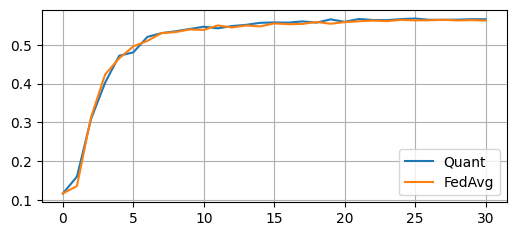

In [12]:
plt.figure(figsize=(6, 2.5)), #iid K=20, L=5, b =10 , lambda 0.2
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major') 
print(np.mean(percentage[:,0:17]))
print(np.mean((32+Bits[:,0:17])/462410))

1.7319435133323244
1.1732635539888845


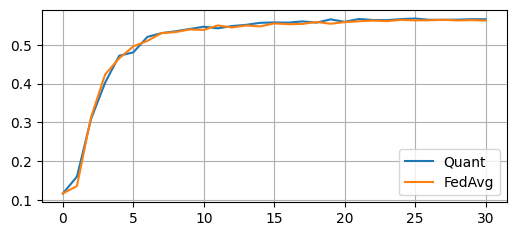

In [13]:
plt.figure(figsize=(6, 2.5)), #non-iid K=20, L=5, b =10 , lambda 0.2
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major') 
print(np.mean(percentage))
print(np.mean((32+Bits)/462410))

In [14]:
print(np.mean(percentage[:,20:30]))

1.9893811768776626


1.7319435133323244
1.1732635539888845


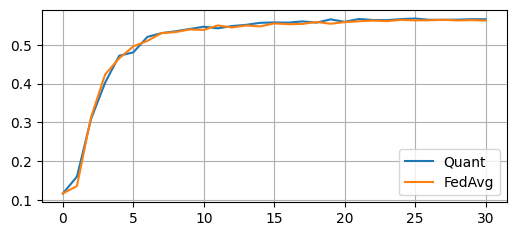

In [15]:
plt.figure(figsize=(6, 2.5)), #non-iid K=40, L=5, b =2 , lambda 0.4
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major') 
print(np.mean(percentage))
print(np.mean((32+Bits)/462410))

1.7319435133323244
1.1732635539888845


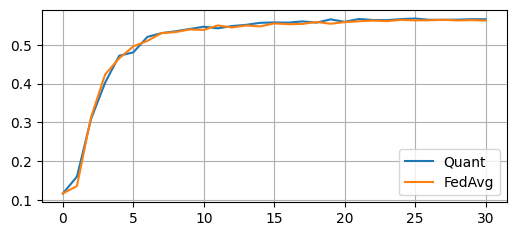

In [17]:
#lambda 0.05, K=20, L=3, b = 2, 4min/iteration, iid
plt.figure(figsize=(6, 2.5))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major') 
print(np.mean(percentage))
print(np.mean((32+Bits)/462410))

In [42]:
#acc_q0_temp = np.array(global_acc_list)
#acc_fed0_temp = np.array(global_acc_list_FedAvg)
#acc_q = acc_q0_temp[0:19]
#acc_fed = acc_fed0_temp[0:19]

In [44]:
run_folder_name = 'Data_K40'
run_folder_path = os.path.join(base_dir, run_folder_name)

# Create the directory if it doesn't exist
os.makedirs(run_folder_path, exist_ok=True)

np.save(client_data, client_data)

TypeError: expected str, bytes or os.PathLike object, not list

In [37]:
acc_q = np.array(global_acc_list)
acc_fed = np.array(global_acc_list_FedAvg)

# Base directory where you want to save the results
base_dir = 'C:/FedASi files'

# Prompt the user to input the folder name
#run_folder_name = input("Enter the folder name for this run: ")
run_folder_name = 'Noniid_K40_L5_b2_T20_lambda0.4'
run_folder_path = os.path.join(base_dir, run_folder_name)

# Create the directory if it doesn't exist
os.makedirs(run_folder_path, exist_ok=True)

# List of matrices to save and their respective filenames
matrices = {
    'A_bar': A_bar,
    'B_bar': B_bar,
    'Bits' : Bits,
    'percentage': percentage,
    'I_M': I_M,
    'B_tilde': B_tilde,
    'Lambda': Lambda,
    'acc_q' : acc_q,
    'acc_fed': acc_fed
    
    # Add more matrices here as needed
}

# Save each matrix to a .npy file in the specified folder
for name, matrix in matrices.items():
    file_name = os.path.join(run_folder_path, f'{name}.npy')
    np.save(file_name, matrix)
    print(f'{name} saved to {file_name}')


A_bar saved to C:/FedASi files\Noniid_K40_L5_b2_T20_lambda0.4\A_bar.npy
B_bar saved to C:/FedASi files\Noniid_K40_L5_b2_T20_lambda0.4\B_bar.npy
Bits saved to C:/FedASi files\Noniid_K40_L5_b2_T20_lambda0.4\Bits.npy
percentage saved to C:/FedASi files\Noniid_K40_L5_b2_T20_lambda0.4\percentage.npy
I_M saved to C:/FedASi files\Noniid_K40_L5_b2_T20_lambda0.4\I_M.npy
B_tilde saved to C:/FedASi files\Noniid_K40_L5_b2_T20_lambda0.4\B_tilde.npy
Lambda saved to C:/FedASi files\Noniid_K40_L5_b2_T20_lambda0.4\Lambda.npy
acc_q saved to C:/FedASi files\Noniid_K40_L5_b2_T20_lambda0.4\acc_q.npy
acc_fed saved to C:/FedASi files\Noniid_K40_L5_b2_T20_lambda0.4\acc_fed.npy


In [ ]:
#second batch of the same simulation for saving time:

In [30]:
#Lambda = Lambda31
Lambda = 0.4*np.ones(K)

# Define neural network architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
# Define the number of clients and local epochs
num_clients= K
#local_epochs = 1
local_epochs0 = 5 #local_epochs FedAvg
local_epochs = 5
epoch_increase = 0
b_j = 4



# Federated Averaging algorithm
num_global_iterations = 50
k_0 = -100 #num_global_iterations +1

#learning_rate = 1e-3
#optimizer = SGD(learning_rate=learning_rate)
optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)

#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4) #


## Split the data into non-overlapping portions for each client

#for i in range(num_clients):
#    start = i * samples_per_client
#    end = (i + 1) * samples_per_client
#    x_client = x_train[start:end]
#    y_client = y_train[start:end]
#    client_data.append((x_client, y_client))


#------------------------------DATASETS--------------------------------------------------

#----------------------------------------------------------------------------------------------
   
    
##Lambda0 = np.random.rand(num_clients)
#Lambda0 = np.abs(np.random.randn(num_clients))
#LAmbda = np.zeros(num_clients)

#for i in range(num_clients):
#    LAmbda[i] = (1 - Lambda0[i]/np.max(Lambda0) + 0.001)
#Lambda = LAmbda/np.sum(LAmbda)
#print('Lambda:', Lambda)
#print('sum lambda:', np.sum(Lambda))
# Initialize the global model
global_model = create_model()


# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#global_model_FedAvg = global_model 
global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
global_weights = global_model.get_weights()
B_q = np.zeros([8,num_global_iterations])

#------------- FedAvg benchmark----------------------


global_model_FedAvg.set_weights(global_weights)
global_acc_list = []
global_loss_list = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list.append(initial_accuracy)

#----------------------------------------------------------------------------------------------

Bits = np.zeros([num_clients, num_global_iterations])
percentage = np.zeros([num_clients, num_global_iterations])
#-----------------------------------------------------
t_start=time.time()
for k in range(num_global_iterations):
    N_total = 0
    
    print(f"Global Iteration {k + 1}/{num_global_iterations}")

    # List to store client models for averaging
    client_models = []
    client_models_FedAvg = []

    for i in range(num_clients):
        print(f"Client {i + 1}/{num_clients}")
        x_local, y_local = client_data[i]

        # Create a copy of the global model for each client
        local_model = create_model()
        local_model.set_weights(global_weights)#global_model.get_weights())
        #----------------------- FedAvg benchmark--------------------------------
        local_model_FedAvg = create_model()
        local_model_FedAvg.set_weights(global_model_FedAvg.get_weights())
        local_model_FedAvg .compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        local_model_FedAvg .fit(x_local, y_local, epochs=local_epochs0, verbose=0)
        
            
        #----------------------------------------------------
        # Compile and train the local model
        local_model.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model.fit(x_local, y_local, epochs=local_epochs , verbose=0)

        if k<= k_0:
            local_model.set_weights(local_model_FedAvg.get_weights())
#--------------------------------------------------- Quantization -----------------------------------------
        if k>k_0:
        # Quantize the local model weights
        #quantized_weights = [np.round(w * 127) / 127 for w in local_model.get_weights()]
            diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights) 
            local_weight_shape_0 = diff_local_global_weight.shape[0]
            quantized_diff_local_global_weight = diff_local_global_weight
            err = np.zeros([local_weight_shape_0 ,1])
            b_p = np.zeros([local_weight_shape_0 ,1])
            b_q =  np.zeros([local_weight_shape_0 ,1])
            x_previous = np.zeros([local_weight_shape_0 ,1])
            x_all_original = np.zeros([local_weight_shape_0 ,1])
            p10 = 0
            x_all = 0
            x = np.zeros([local_weight_shape_0,1])
            Quantized_diff_local_global_weight = []
            for h in range(local_weight_shape_0):
                x_position = 0
                if h==0:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(27*32,)
                    #Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
               ## quantized_diff_local_global_weight[h], tau, err[h], r = Quantization_NNs(bits,R,diff_local_global_weight[h])
                if h==2:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200*64,)
                
                if h in (1, 3, 5):
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(quantized_diff_local_global_weight[h].shape[0],)
                
                #if h==6:
                   # quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,1)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10*64,)
                
               #### x_previous[h] = np.max(abs(quantized_diff_local_global_weight[h]))
                ####x_position = np.where(np.abs(quantized_diff_local_global_weight[h]) == 
                ####                      max(np.abs(quantized_diff_local_global_weight[h])))
                ####x_temp=quantized_diff_local_global_weight[h] 
                ####x_all_original[h] = x_temp[x_position[0][0]] 
                #print(x[b[0][0]])
            
            #print(x_previous.T)
            ####x_all = np.max(x_previous)
           #### x_position_all = np.where(np.abs(x_previous) == max(np.abs(x_previous)))
            ####x_all_original1 = x_all_original[x_position_all[0][0]]
           #### print('x_all_original1:', x_all_original1)
            
           #### #print(x_previous.T)
            ####x_all = np.max(x_previous)
            #print('x_all:', x_all)
            
            for h in range(local_weight_shape_0):
                Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
           
            
            Quantized_diff_local_global_weight_for_me = Quantized_diff_local_global_weight
            print('max:',np.max(Quantized_diff_local_global_weight), '----min:',np.min(Quantized_diff_local_global_weight))
           
        # print('min:',np.min(Quantized_diff_local_global_weight))
        
            #nmax = 10000#min(2000*(2+k), 50000)
            #nmin = nmax
           # print( 'min of absolute value:',np.min(np.abs(Quantized_diff_local_global_weight)))
            #Quantized_diff_local_global_weight, max_model, min_model, err = adaptive_signQuant(Quantized_diff_local_global_weight, Quantized_diff_local_global_weight.shape[0], nmax,nmin)
            
            Quantized_diff_local_global_weight, max_model, min_model, err, n_max, n_min, x_min_me = adaptive_signQuant_lambda(Quantized_diff_local_global_weight, 
                                                                                                       Quantized_diff_local_global_weight.shape[0], Lambda[i], b_j)
            
            print('n_max:', n_max, 'n_min:', n_min, 'Lambda_j:', Lambda[i])
            N_total += n_max + n_min
            Bits[i,k] = (462410 - n_max - n_min) + (b_j+1)*(n_max + n_min)
            Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
           
            print('max error:', np.max(np.abs(err)))# - np.sum(Quantized_diff_local_global_weight1))
            #print('sum 1r:', np.sum(Quantized_diff_local_global_weight1))
            #print('max_model:', max_model)
            #print('min_model:', min_model)
            print('max_model:', 1*max_model, 'min_model:', 1*min_model, 'x_min_me:', x_min_me)
            percentage[i,k] = 100*(n_min+n_max)/462410
            print('percentage %:', percentage[i,k] )
            #------------------ Update the local model with quantized weights:-----------------------------
            dim_h = 0
            for h in range(local_weight_shape_0):
                if h==0:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[0:27*32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(3, 3, 3, 32)
                    dim_h += 27*32
                    
                    
                if h==1:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,)
                    dim_h += 32
                if h==2: 
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+7200*64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200, 64)
                    dim_h+= 7200*64
                if h==3:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,)
                    dim_h += 64
            
                #if h==6:
                 #   quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+640]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    dim_h += 640
              
                if h==5:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+10]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10,)
                    dim_h += 10
            
            
            local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))
        #else:
           # local_model.set_weights()
            
        # Add the trained and quantized local model to the list
        client_models.append(local_model)
        client_models_FedAvg.append(local_model_FedAvg)
        #B_q[:,k] += b_q
            
        #---------------------------FedAvg benchmark---------------------------------
    #print('nmax:', nmax)
    global_weights_FedAvg = np.mean([model0.get_weights() for model0 in client_models_FedAvg], axis=0)
    global_model_FedAvg.set_weights(global_weights_FedAvg)

#------------------------------------------------------------------------------------------------------------
    # Calculate the global model's new weights as the average of the client models
    if k <= k_0:
        global_model.set_weights(global_weights_FedAvg)
        global_weights = global_weights_FedAvg
    else:
        global_weights = np.mean([model.get_weights() for model in client_models], axis=0)
        global_model.set_weights(global_weights)
        #local_epochs = min(12, local_epochs + epoch_increase)
        #local_epochs += epoch_increase
        #local_epochs0 = local_epochs
        #local_epochs = max(1, local_epochs)
    
    if k == k_0:
        local_epochs += epoch_increase
        local_epochs0 = local_epochs
   # B_q[:,k] = b_q
#----------------------------------------------------------------------------
    # Evaluate the global model on the test data
    print('------------------------------------------------------------------------------------------------------')
    print('N_total:', N_total)
    loss, accuracy = global_model.evaluate(x_test, y_test)
    print(f"Global Test loss: {loss:.4f}, Global Test accuracy: {accuracy:.4f}")
    
    global_acc_list.append(accuracy)
    global_loss_list.append(loss)
   # print('Lambda:',Lambda)
# The final global model is stored in 'global_model'
#-------------------------------------Evaluate the FedAvg global model on the test data----------------------
    print('------------------------------ ------FedAvg Benchmark------------------------------------------------')
    loss_FedAvg, accuracy_FedAvg = global_model_FedAvg.evaluate(x_test, y_test)
    print(f"_FedAvg Global Test loss: {loss_FedAvg:.4f}, _FedAvg Global Test accuracy: {accuracy_FedAvg:.4f}")
    print('------------------------------------------------------------------------------------------------------')
    global_acc_list_FedAvg.append(accuracy_FedAvg)
    global_loss_list_FedAvg.append(loss_FedAvg)
    #----------------
   # plt.figure(figsize=(7, 3))
   # plt.plot(global_acc_list)    
   # plt.plot(global_acc_list_FedAvg)
   # plt.legend(['Quant', 'FedAvg'])
   # plt.grid(True, which='major')   
    
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)            
print(np.mean(percentage))
print(np.mean((32+Bits)/462410))            
            

313/313 [==============================] - 1s 2ms/step - loss: 2.3357 - accuracy: 0.1072
Initial Test Loss: 2.3357
Initial Test Accuracy: 0.1072
Global Iteration 1/50
Client 1/40


KeyError: in user code:

    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\engine\training.py", line 1054, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\optimizers\optimizer.py", line 543, in minimize
        self.apply_gradients(grads_and_vars)
    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\optimizers\optimizer.py", line 1174, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\optimizers\optimizer.py", line 650, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\optimizers\optimizer.py", line 1200, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\optimizers\optimizer.py", line 1250, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\optimizers\optimizer.py", line 1247, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "C:\Users\karen\anaconda3\envs\new_artigo\lib\site-packages\keras\optimizers\optimizer.py", line 232, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable conv2d_46/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adagrad.'


max: 0.39974260330200195 ----min: -0.39565563201904297
n_max: 59 n_min: 30 Lambda_j: 0.4
max error: 0.0799485169351101
max_model: 0.1598970413208008 min_model: -0.1598970413208008 x_min_me: 0.1598970413208008
percentage %: 0.01924698860318765
Client 5/40
max: 0.3235419988632202 ----min: -0.3315931558609009
n_max: 79 n_min: 44 Lambda_j: 0.4
max error: 0.06631863070651889
max_model: 0.13263726234436035 min_model: -0.13263726234436035 x_min_me: 0.13263726234436035
percentage %: 0.026599770766203155
Client 6/40
max: 0.3028485178947449 ----min: -0.4767899215221405
n_max: 28 n_min: 21 Lambda_j: 0.4
max error: 0.0953579805791378
max_model: 0.1907159686088562 min_model: -0.1907159686088562 x_min_me: 0.1907159686088562
percentage %: 0.010596656646698817
Client 7/40
max: 0.41643986105918884 ----min: -0.3576708734035492
n_max: 57 n_min: 29 Lambda_j: 0.4
max error: 0.08328797058202325
max_model: 0.16657594442367551 min_model: -0.16657594442367551 x_min_me: 0.16657594442367551
percentage %: 0.01859

max: 0.2612984776496887 ----min: -0.26144543290138245
n_max: 119 n_min: 52 Lambda_j: 0.4
max error: 0.052289086114615205
max_model: 0.10457817316055298 min_model: -0.10457817316055298 x_min_me: 0.10457817316055298
percentage %: 0.03698016911398975
Client 37/40
max: 0.42546790838241577 ----min: -0.3363840579986572
n_max: 42 n_min: 14 Lambda_j: 0.4
max error: 0.08509358074516057
max_model: 0.1701871633529663 min_model: -0.1701871633529663 x_min_me: 0.1701871633529663
percentage %: 0.012110464739084363
Client 38/40
max: 0.4702693819999695 ----min: -0.27493929862976074
n_max: 33 n_min: 14 Lambda_j: 0.4
max error: 0.09405387267470361
max_model: 0.18810775279998782 min_model: -0.18810775279998782 x_min_me: 0.18810775279998782
percentage %: 0.010164140048874375
Client 39/40
max: 0.3282054662704468 ----min: -0.2487163096666336
n_max: 86 n_min: 44 Lambda_j: 0.4
max error: 0.06564109232276677
max_model: 0.1312821865081787 min_model: -0.1312821865081787 x_min_me: 0.1312821865081787
percentage %: 

max: 0.3240709602832794 ----min: -0.3483644723892212
n_max: 55 n_min: 45 Lambda_j: 0.4
max error: 0.06967289401218295
max_model: 0.13934578895568847 min_model: -0.13934578895568847 x_min_me: 0.13934578895568847
percentage %: 0.021625829891222074
Client 27/40
max: 0.38106197118759155 ----min: -0.2711154818534851
n_max: 57 n_min: 29 Lambda_j: 0.4
max error: 0.07621239237487315
max_model: 0.1524247884750366 min_model: -0.1524247884750366 x_min_me: 0.1524247884750366
percentage %: 0.018598213706450983
Client 28/40
max: 0.3565167188644409 ----min: -0.2938135862350464
n_max: 45 n_min: 30 Lambda_j: 0.4
max error: 0.07130334191024304
max_model: 0.14260668754577638 min_model: -0.14260668754577638 x_min_me: 0.14260668754577638
percentage %: 0.016219372418416558
Client 29/40
max: 0.3232199251651764 ----min: -0.24118109047412872
n_max: 89 n_min: 53 Lambda_j: 0.4
max error: 0.06464398317039012
max_model: 0.12928797006607054 min_model: -0.12928797006607054 x_min_me: 0.12928797006607054
percentage %:

max: 0.289450466632843 ----min: -0.2782638370990753
n_max: 88 n_min: 73 Lambda_j: 0.4
max error: 0.057890091463923446
max_model: 0.11578018665313719 min_model: -0.11578018665313719 x_min_me: 0.11578018665313719
percentage %: 0.034817586124867544
Client 17/40
max: 0.3429848551750183 ----min: -0.2806432843208313
n_max: 61 n_min: 46 Lambda_j: 0.4
max error: 0.0685969702200964
max_model: 0.13719394207000732 min_model: -0.13719394207000732 x_min_me: 0.13719394207000732
percentage %: 0.02313963798360762
Client 18/40
max: 0.29717475175857544 ----min: -0.2611265778541565
n_max: 114 n_min: 109 Lambda_j: 0.4
max error: 0.05943494848906994
max_model: 0.11886990070343018 min_model: -0.11886990070343018 x_min_me: 0.11886990070343018
percentage %: 0.048225600657425226
Client 19/40
max: 0.3319413363933563 ----min: -0.28325799107551575
n_max: 78 n_min: 33 Lambda_j: 0.4
max error: 0.06638826355338096
max_model: 0.1327765345573425 min_model: -0.1327765345573425 x_min_me: 0.1327765345573425
percentage %:

n_max: 115 n_min: 80 Lambda_j: 0.4
max error: 0.05075367063982412
max_model: 0.10150734186172485 min_model: -0.10150734186172485 x_min_me: 0.10150734186172485
percentage %: 0.04217036828788305
Client 6/40
max: 0.30807259678840637 ----min: -0.34048351645469666
n_max: 104 n_min: 57 Lambda_j: 0.4
max error: 0.06809669956564902
max_model: 0.13619340658187865 min_model: -0.13619340658187865 x_min_me: 0.13619340658187865
percentage %: 0.034817586124867544
Client 7/40
max: 0.2969992160797119 ----min: -0.27497389912605286
n_max: 85 n_min: 65 Lambda_j: 0.4
max error: 0.059399839490652084
max_model: 0.11879968643188477 min_model: -0.11879968643188477 x_min_me: 0.11879968643188477
percentage %: 0.032438744836833115
Client 8/40
max: 0.3542105555534363 ----min: -0.25625231862068176
n_max: 52 n_min: 40 Lambda_j: 0.4
max error: 0.07084210738539695
max_model: 0.1416842222213745 min_model: -0.1416842222213745 x_min_me: 0.1416842222213745
percentage %: 0.01989576349992431
Client 9/40
max: 0.286285638809

max: 0.29373985528945923 ----min: -0.2897934019565582
n_max: 90 n_min: 63 Lambda_j: 0.4
max error: 0.05874796942807734
max_model: 0.1174959421157837 min_model: -0.1174959421157837 x_min_me: 0.1174959421157837
percentage %: 0.03308751973356978
Client 38/40
max: 0.3572525382041931 ----min: -0.2633621394634247
n_max: 47 n_min: 24 Lambda_j: 0.4
max error: 0.07145050577819348
max_model: 0.14290101528167726 min_model: -0.14290101528167726 x_min_me: 0.14290101528167726
percentage %: 0.015354339222767674
Client 39/40
max: 0.2761485278606415 ----min: -0.20599707961082458
n_max: 97 n_min: 68 Lambda_j: 0.4
max error: 0.05522970370948315
max_model: 0.1104594111442566 min_model: -0.1104594111442566 x_min_me: 0.1104594111442566
percentage %: 0.035682619320516425
Client 40/40
max: 0.44504258036613464 ----min: -0.3843154013156891
n_max: 36 n_min: 12 Lambda_j: 0.4
max error: 0.08900851514190436
max_model: 0.17801703214645387 min_model: -0.20768653750419616 x_min_me: 0.17801703214645387
percentage %: 0.

n_max: 60 n_min: 45 Lambda_j: 0.4
max error: 0.06412588860839605
max_model: 0.12825177907943724 min_model: -0.12825177907943724 x_min_me: 0.12825177907943724
percentage %: 0.02270712138578318
Client 27/40
max: 0.31724321842193604 ----min: -0.2791976034641266
n_max: 51 n_min: 30 Lambda_j: 0.4
max error: 0.06344864345155657
max_model: 0.12689728736877443 min_model: -0.12689728736877443 x_min_me: 0.12689728736877443
percentage %: 0.01751692221188988
Client 28/40
max: 0.3870704472064972 ----min: -0.33851301670074463
n_max: 27 n_min: 13 Lambda_j: 0.4
max error: 0.07741408920846879
max_model: 0.15482817888259887 min_model: -0.18063287536303202 x_min_me: 0.15482817888259887
percentage %: 0.00865033195648883
Client 29/40
max: 0.3312262296676636 ----min: -0.2941611707210541
n_max: 73 n_min: 45 Lambda_j: 0.4
max error: 0.06624524552607909
max_model: 0.13249049186706544 min_model: -0.13249049186706544 x_min_me: 0.13249049186706544
percentage %: 0.02551847927164205
Client 30/40
max: 0.266043901443

max: 0.24528120458126068 ----min: -0.3228514790534973
n_max: 42 n_min: 30 Lambda_j: 0.4
max error: 0.06457029487937689
max_model: 0.12914059162139893 min_model: -0.12914059162139893 x_min_me: 0.12914059162139893
percentage %: 0.015570597521679894
Client 17/40
max: 0.2879747152328491 ----min: -0.2530141770839691
n_max: 113 n_min: 61 Lambda_j: 0.4
max error: 0.05759494118392468
max_model: 0.11518988609313965 min_model: -0.11518988609313965 x_min_me: 0.11518988609313965
percentage %: 0.03762894401072641
Client 18/40
max: 0.25384658575057983 ----min: -0.31209298968315125
n_max: 85 n_min: 69 Lambda_j: 0.4
max error: 0.06241859677247703
max_model: 0.12483719587326049 min_model: -0.12483719587326049 x_min_me: 0.12483719587326049
percentage %: 0.033303778032481995
Client 19/40
max: 0.28542250394821167 ----min: -0.28543615341186523
n_max: 89 n_min: 71 Lambda_j: 0.4
max error: 0.05708722835406661
max_model: 0.1141744613647461 min_model: -0.1141744613647461 x_min_me: 0.1141744613647461
percentage

n_max: 82 n_min: 39 Lambda_j: 0.4
max error: 0.05420504770954721
max_model: 0.10841009616851806 min_model: -0.10841009616851806 x_min_me: 0.10841009616851806
percentage %: 0.02616725416837871
Client 6/40
max: 0.24202591180801392 ----min: -0.29669368267059326
n_max: 164 n_min: 137 Lambda_j: 0.4
max error: 0.05933873280882836
max_model: 0.11867747306823731 min_model: -0.11867747306823731 x_min_me: 0.11867747306823731
percentage %: 0.06509374797257844
Client 7/40
max: 0.2343519926071167 ----min: -0.23705878853797913
n_max: 261 n_min: 149 Lambda_j: 0.4
max error: 0.04741175677627325
max_model: 0.09482351541519166 min_model: -0.09482351541519166 x_min_me: 0.09482351541519166
percentage %: 0.08866590255401051
Client 8/40
max: 0.31361231207847595 ----min: -0.24512675404548645
n_max: 84 n_min: 52 Lambda_j: 0.4
max error: 0.06272246148437262
max_model: 0.1254449248313904 min_model: -0.1254449248313904 x_min_me: 0.1254449248313904
percentage %: 0.029411128652062024
Client 9/40
max: 0.38601756095

max: 0.25360915064811707 ----min: -0.33423659205436707
n_max: 47 n_min: 22 Lambda_j: 0.4
max error: 0.06684731829445809
max_model: 0.13369463682174682 min_model: -0.13369463682174682 x_min_me: 0.13369463682174682
percentage %: 0.014921822624943232
Client 38/40
max: 0.28715628385543823 ----min: -0.22889849543571472
n_max: 77 n_min: 33 Lambda_j: 0.4
max error: 0.05743124932050704
max_model: 0.11486251354217528 min_model: -0.11486251354217528 x_min_me: 0.11486251354217528
percentage %: 0.023788412880344282
Client 39/40
max: 0.27250462770462036 ----min: -0.27962303161621094
n_max: 79 n_min: 42 Lambda_j: 0.4
max error: 0.05592460539191961
max_model: 0.11184921264648437 min_model: -0.11184921264648437 x_min_me: 0.11184921264648437
percentage %: 0.02616725416837871
Client 40/40
max: 0.38254639506340027 ----min: -0.2612944543361664
n_max: 33 n_min: 6 Lambda_j: 0.4
max error: 0.07650927889626474
max_model: 0.15301855802536013 min_model: -0.15301855802536013 x_min_me: 0.15301855802536013
percent

max: 0.30158454179763794 ----min: -0.3474324345588684
n_max: 29 n_min: 26 Lambda_j: 0.4
max error: 0.06948648667894303
max_model: 0.13897297382354734 min_model: -0.13897297382354734 x_min_me: 0.13897297382354734
percentage %: 0.011894206440172141
Client 27/40
max: 0.3065081238746643 ----min: -0.2836322486400604
n_max: 49 n_min: 22 Lambda_j: 0.4
max error: 0.06130162430927157
max_model: 0.12260324954986572 min_model: -0.12260324954986572 x_min_me: 0.12260324954986572
percentage %: 0.015354339222767674
Client 28/40
max: 0.26204895973205566 ----min: -0.17056986689567566
n_max: 48 n_min: 19 Lambda_j: 0.4
max error: 0.05240979180816793
max_model: 0.10481958389282225 min_model: -0.10481958389282225 x_min_me: 0.10481958389282225
percentage %: 0.01448930602711879
Client 29/40
max: 0.24664558470249176 ----min: -0.2314043939113617
n_max: 220 n_min: 223 Lambda_j: 0.4
max error: 0.04932911670766771
max_model: 0.0986582338809967 min_model: -0.0986582338809967 x_min_me: 0.0986582338809967
percentage

n_max: 41 n_min: 22 Lambda_j: 0.4
max error: 0.0688344519585371
max_model: 0.1376689076423645 min_model: -0.1376689076423645 x_min_me: 0.1376689076423645
percentage %: 0.013624272831469908
Client 16/40
max: 0.2369624376296997 ----min: -0.2535632848739624
n_max: 132 n_min: 100 Lambda_j: 0.4
max error: 0.0507126560434699
max_model: 0.10142531394958496 min_model: -0.10142531394958496 x_min_me: 0.10142531394958496
percentage %: 0.05017192534763522
Client 17/40
max: 0.2680995464324951 ----min: -0.25015079975128174
n_max: 198 n_min: 173 Lambda_j: 0.4
max error: 0.05361990742385388
max_model: 0.10723981857299805 min_model: -0.10723981857299805 x_min_me: 0.10723981857299805
percentage %: 0.0802318288964339
Client 18/40
max: 0.2482863962650299 ----min: -0.3062821626663208
n_max: 119 n_min: 72 Lambda_j: 0.4
max error: 0.06125643227132968
max_model: 0.12251286506652831 min_model: -0.12251286506652831 x_min_me: 0.12251286506652831
percentage %: 0.04130533509223416
Client 19/40
max: 0.2922774255275

max: 0.2352612316608429 ----min: -0.2186690866947174
n_max: 72 n_min: 42 Lambda_j: 0.4
max error: 0.047052246303064746
max_model: 0.09410449266433715 min_model: -0.09410449266433715 x_min_me: 0.09410449266433715
percentage %: 0.024653446075993166
Client 6/40
max: 0.28607743978500366 ----min: -0.2669450044631958
n_max: 121 n_min: 81 Lambda_j: 0.4
max error: 0.05721548702567816
max_model: 0.11443097591400148 min_model: -0.11443097591400148 x_min_me: 0.11443097591400148
percentage %: 0.04368417638026859
Client 7/40
max: 0.21467426419258118 ----min: -0.2005292773246765
n_max: 270 n_min: 232 Lambda_j: 0.4
max error: 0.04293485097587109
max_model: 0.08586970567703248 min_model: -0.08586970567703248 x_min_me: 0.08586970567703248
percentage %: 0.10856166605393482
Client 8/40
max: 0.24744507670402527 ----min: -0.21068137884140015
n_max: 322 n_min: 377 Lambda_j: 0.4
max error: 0.049489014293067166
max_model: 0.09897803068161012 min_model: -0.09897803068161012 x_min_me: 0.09897803068161012
percen

max: 0.27031582593917847 ----min: -0.28299760818481445
n_max: 62 n_min: 65 Lambda_j: 0.4
max error: 0.056599521627867945
max_model: 0.11319904327392578 min_model: -0.11319904327392578 x_min_me: 0.11319904327392578
percentage %: 0.027464803961852035
Client 38/40
max: 0.2577880024909973 ----min: -0.3158167600631714
n_max: 42 n_min: 22 Lambda_j: 0.4
max error: 0.0631633510813117
max_model: 0.12632670402526855 min_model: -0.12632670402526855 x_min_me: 0.12632670402526855
percentage %: 0.013840531130382128
Client 39/40
max: 0.23351657390594482 ----min: -0.2102481722831726
n_max: 119 n_min: 106 Lambda_j: 0.4
max error: 0.04670331454835832
max_model: 0.09340662956237793 min_model: -0.09340662956237793 x_min_me: 0.09340662956237793
percentage %: 0.04865811725524967
Client 40/40
max: 0.36515355110168457 ----min: -0.42196571826934814
n_max: 18 n_min: 14 Lambda_j: 0.4
max error: 0.08439314353745431
max_model: 0.16878628730773926 min_model: -0.16878628730773926 x_min_me: 0.16878628730773926
percen

n_max: 59 n_min: 37 Lambda_j: 0.4
max error: 0.05472543216310441
max_model: 0.1094508647918701 min_model: -0.1094508647918701 x_min_me: 0.1094508647918701
percentage %: 0.020760796695573194
Client 27/40
max: 0.2216981053352356 ----min: -0.2699526846408844
n_max: 69 n_min: 25 Lambda_j: 0.4
max error: 0.0539905367535539
max_model: 0.10798107385635376 min_model: -0.10798107385635376 x_min_me: 0.10798107385635376
percentage %: 0.02032828009774875
Client 28/40
max: 0.28322833776474 ----min: -0.21459142863750458
n_max: 38 n_min: 19 Lambda_j: 0.4
max error: 0.056645667465636505
max_model: 0.113291335105896 min_model: -0.113291335105896 x_min_me: 0.113291335105896
percentage %: 0.012326723037996583
Client 29/40
max: 0.26120245456695557 ----min: -0.3430793285369873
n_max: 54 n_min: 64 Lambda_j: 0.4
max error: 0.06861586477607488
max_model: 0.13723173141479492 min_model: -0.13723173141479492 x_min_me: 0.13723173141479492
percentage %: 0.02551847927164205
Client 30/40
max: 0.271787166595459 ----m

max: 0.2593023478984833 ----min: -0.2484208196401596
n_max: 76 n_min: 55 Lambda_j: 0.4
max error: 0.051860469463281336
max_model: 0.10372093915939332 min_model: -0.10372093915939332 x_min_me: 0.10372093915939332
percentage %: 0.02832983715750092
Client 17/40
max: 0.3031744360923767 ----min: -0.2595268487930298
n_max: 61 n_min: 33 Lambda_j: 0.4
max error: 0.060634885355830184
max_model: 0.12126977443695067 min_model: -0.12126977443695067 x_min_me: 0.12126977443695067
percentage %: 0.02032828009774875
Client 18/40
max: 0.24791592359542847 ----min: -0.317859411239624
n_max: 59 n_min: 73 Lambda_j: 0.4
max error: 0.0635718785226345
max_model: 0.1271437644958496 min_model: -0.1271437644958496 x_min_me: 0.1271437644958496
percentage %: 0.02854609545641314
Client 19/40
max: 0.23666346073150635 ----min: -0.19653862714767456
n_max: 88 n_min: 81 Lambda_j: 0.4
max error: 0.04733269162243232
max_model: 0.09466538429260253 min_model: -0.09466538429260253 x_min_me: 0.09466538429260253
percentage %: 0

n_max: 84 n_min: 41 Lambda_j: 0.4
max error: 0.050217055808752784
max_model: 0.10043411254882814 min_model: -0.10043411254882814 x_min_me: 0.10043411254882814
percentage %: 0.027032287364027595
Client 6/40
max: 0.26576149463653564 ----min: -0.26083847880363464
n_max: 202 n_min: 167 Lambda_j: 0.4
max error: 0.05315229799598456
max_model: 0.10630459785461427 min_model: -0.10630459785461427 x_min_me: 0.10630459785461427
percentage %: 0.07979931229860945
Client 7/40
max: 0.21676436066627502 ----min: -0.23439395427703857
n_max: 204 n_min: 140 Lambda_j: 0.4
max error: 0.04687878899276257
max_model: 0.09375758171081544 min_model: -0.09375758171081544 x_min_me: 0.09375758171081544
percentage %: 0.07439285482580393
Client 8/40
max: 0.2035140097141266 ----min: -0.18982911109924316
n_max: 459 n_min: 303 Lambda_j: 0.4
max error: 0.040702801477164034
max_model: 0.08140560388565064 min_model: -0.08140560388565064 x_min_me: 0.08140560388565064
percentage %: 0.1647888237711122
Client 9/40
max: 0.33364

max: 0.22160452604293823 ----min: -0.24848897755146027
n_max: 81 n_min: 54 Lambda_j: 0.4
max error: 0.04969779504463077
max_model: 0.09939559102058411 min_model: -0.09939559102058411 x_min_me: 0.09939559102058411
percentage %: 0.029194870353149802
Client 38/40
max: 0.3043202757835388 ----min: -0.22742673754692078
n_max: 46 n_min: 18 Lambda_j: 0.4
max error: 0.060864054574631156
max_model: 0.12172811031341553 min_model: -0.12172811031341553 x_min_me: 0.12172811031341553
percentage %: 0.013840531130382128
Client 39/40
max: 0.237348735332489 ----min: -0.20642271637916565
n_max: 124 n_min: 85 Lambda_j: 0.4
max error: 0.04746974695008248
max_model: 0.0949394941329956 min_model: -0.0949394941329956 x_min_me: 0.0949394941329956
percentage %: 0.045197984472654135
Client 40/40
max: 0.2823498845100403 ----min: -0.38552939891815186
n_max: 27 n_min: 14 Lambda_j: 0.4
max error: 0.07710587931796908
max_model: 0.15421175956726074 min_model: -0.15421175956726074 x_min_me: 0.15421175956726074
percentag

n_max: 58 n_min: 45 Lambda_j: 0.4
max error: 0.05925921178422868
max_model: 0.11851842403411865 min_model: -0.11851842403411865 x_min_me: 0.11851842403411865
percentage %: 0.022274604787958736
Client 27/40
max: 0.22543403506278992 ----min: -0.34026628732681274
n_max: 28 n_min: 14 Lambda_j: 0.4
max error: 0.06805325734894724
max_model: 0.13610651493072512 min_model: -0.13610651493072512 x_min_me: 0.13610651493072512
percentage %: 0.009082848554313272
Client 28/40
max: 0.22144143283367157 ----min: -0.1915903091430664
n_max: 76 n_min: 33 Lambda_j: 0.4
max error: 0.04428828652307856
max_model: 0.08857657313346862 min_model: -0.08857657313346862 x_min_me: 0.08857657313346862
percentage %: 0.023572154581432064
Client 29/40
max: 0.36983558535575867 ----min: -0.21785037219524384
n_max: 15 n_min: 12 Lambda_j: 0.4
max error: 0.07396711648907511
max_model: 0.14793423414230344 min_model: -0.14793423414230344 x_min_me: 0.14793423414230344
percentage %: 0.0058389740706299605
Client 30/40
max: 0.2077

max: 0.37264782190322876 ----min: -0.2443067729473114
n_max: 21 n_min: 15 Lambda_j: 0.4
max error: 0.07452956391498447
max_model: 0.14905912876129152 min_model: -0.14905912876129152 x_min_me: 0.14905912876129152
percentage %: 0.007785298760839947
Client 17/40
max: 0.3469809591770172 ----min: -0.18059825897216797
n_max: 26 n_min: 11 Lambda_j: 0.4
max error: 0.06939619125332684
max_model: 0.1387923836708069 min_model: -0.1387923836708069 x_min_me: 0.1387923836708069
percentage %: 0.008001557059752168
Client 18/40
max: 0.225382000207901 ----min: -0.2740875482559204
n_max: 128 n_min: 62 Lambda_j: 0.4
max error: 0.054817508719861505
max_model: 0.10963501930236816 min_model: -0.10963501930236816 x_min_me: 0.10963501930236816
percentage %: 0.041089076793321945
Client 19/40
max: 0.20866507291793823 ----min: -0.1923934370279312
n_max: 313 n_min: 202 Lambda_j: 0.4
max error: 0.04173301365226507
max_model: 0.08346602916717528 min_model: -0.08346602916717528 x_min_me: 0.08346602916717528
percentag

n_max: 80 n_min: 86 Lambda_j: 0.4
max error: 0.04948716415092349
max_model: 0.09897432923316955 min_model: -0.09897432923316955 x_min_me: 0.09897432923316955
percentage %: 0.03589887761942864
Client 6/40
max: 0.2549384832382202 ----min: -0.23967301845550537
n_max: 207 n_min: 207 Lambda_j: 0.4
max error: 0.05098769618198275
max_model: 0.10197539329528807 min_model: -0.10197539329528807 x_min_me: 0.10197539329528807
percentage %: 0.0895309357496594
Client 7/40
max: 0.21202825009822845 ----min: -0.2148473858833313
n_max: 209 n_min: 145 Lambda_j: 0.4
max error: 0.04296947694383561
max_model: 0.08593895435333251 min_model: -0.08593895435333251 x_min_me: 0.08593895435333251
percentage %: 0.07655543781492614
Client 8/40
max: 0.2123141586780548 ----min: -0.20344126224517822
n_max: 474 n_min: 413 Lambda_j: 0.4
max error: 0.04246283126994967
max_model: 0.08492566347122192 min_model: -0.08492566347122192 x_min_me: 0.08492566347122192
percentage %: 0.1918211111351398
Client 9/40
max: 0.33935320377

max: 0.3152386248111725 ----min: -0.30706873536109924
n_max: 41 n_min: 27 Lambda_j: 0.4
max error: 0.06304772472940386
max_model: 0.126095449924469 min_model: -0.126095449924469 x_min_me: 0.126095449924469
percentage %: 0.014705564326031012
Client 38/40
max: 0.23798587918281555 ----min: -0.19248372316360474
n_max: 105 n_min: 56 Lambda_j: 0.4
max error: 0.04759717490524054
max_model: 0.09519435167312623 min_model: -0.09519435167312623 x_min_me: 0.09519435167312623
percentage %: 0.034817586124867544
Client 39/40
max: 0.27720630168914795 ----min: -0.21178248524665833
n_max: 41 n_min: 30 Lambda_j: 0.4
max error: 0.05544126022141427
max_model: 0.11088252067565918 min_model: -0.11088252067565918 x_min_me: 0.11088252067565918
percentage %: 0.015354339222767674
Client 40/40
max: 0.23723727464675903 ----min: -0.1669812798500061
n_max: 56 n_min: 38 Lambda_j: 0.4
max error: 0.047447453998029236
max_model: 0.09489490985870362 min_model: -0.09489490985870362 x_min_me: 0.09489490985870362
percentage

n_max: 79 n_min: 57 Lambda_j: 0.4
max error: 0.04745770681183785
max_model: 0.09491541385650634 min_model: -0.09491541385650634 x_min_me: 0.09491541385650634
percentage %: 0.029411128652062024
Client 27/40
max: 0.22641456127166748 ----min: -0.2796900272369385
n_max: 34 n_min: 14 Lambda_j: 0.4
max error: 0.05593800498172641
max_model: 0.11187601089477539 min_model: -0.11187601089477539 x_min_me: 0.11187601089477539
percentage %: 0.010380398347786597
Client 28/40
max: 0.20774927735328674 ----min: -0.15750211477279663
n_max: 73 n_min: 34 Lambda_j: 0.4
max error: 0.041549855456105435
max_model: 0.0830997109413147 min_model: -0.0830997109413147 x_min_me: 0.0830997109413147
percentage %: 0.02313963798360762
Client 29/40
max: 0.2836965322494507 ----min: -0.19440844655036926
n_max: 62 n_min: 32 Lambda_j: 0.4
max error: 0.05673930551856757
max_model: 0.11347861289978028 min_model: -0.11347861289978028 x_min_me: 0.11347861289978028
percentage %: 0.02032828009774875
Client 30/40
max: 0.2887922227

max: 0.2957680821418762 ----min: -0.21099430322647095
n_max: 55 n_min: 36 Lambda_j: 0.4
max error: 0.05915361596271396
max_model: 0.11830723285675049 min_model: -0.11830723285675049 x_min_me: 0.11830723285675049
percentage %: 0.01967950520101209
Client 17/40
max: 0.2555210292339325 ----min: -0.22648191452026367
n_max: 99 n_min: 54 Lambda_j: 0.4
max error: 0.051104205381125214
max_model: 0.102208411693573 min_model: -0.102208411693573 x_min_me: 0.102208411693573
percentage %: 0.03308751973356978
Client 18/40
max: 0.2329862117767334 ----min: -0.3943788707256317
n_max: 9 n_min: 9 Lambda_j: 0.4
max error: 0.07887577321380376
max_model: 0.15775154829025267 min_model: -0.15775154829025267 x_min_me: 0.15775154829025267
percentage %: 0.0038926493804199735
Client 19/40
max: 0.21030905842781067 ----min: -0.17757397890090942
n_max: 204 n_min: 235 Lambda_j: 0.4
max error: 0.04206181052140892
max_model: 0.08412362337112428 min_model: -0.08412362337112428 x_min_me: 0.08412362337112428
percentage %: 

n_max: 25 n_min: 7 Lambda_j: 0.4
max error: 0.059216492902487525
max_model: 0.11843298673629762 min_model: -0.11843298673629762 x_min_me: 0.11843298673629762
percentage %: 0.006920265565191064
Client 6/40
max: 0.2588094174861908 ----min: -0.22020936012268066
n_max: 129 n_min: 132 Lambda_j: 0.4
max error: 0.05176188326440752
max_model: 0.10352376699447632 min_model: -0.10352376699447632 x_min_me: 0.10352376699447632
percentage %: 0.05644341601608962
Client 7/40
max: 0.23217561841011047 ----min: -0.23015767335891724
n_max: 189 n_min: 150 Lambda_j: 0.4
max error: 0.04643512275069952
max_model: 0.09287024736404419 min_model: -0.09287024736404419 x_min_me: 0.09287024736404419
percentage %: 0.07331156333124283
Client 8/40
max: 0.1957416534423828 ----min: -0.20718416571617126
n_max: 487 n_min: 459 Lambda_j: 0.4
max error: 0.04143683267757297
max_model: 0.08287366628646851 min_model: -0.08287366628646851 x_min_me: 0.08287366628646851
percentage %: 0.20458035077096084
Client 9/40
max: 0.2628173

max: 0.24908249080181122 ----min: -0.2089981734752655
n_max: 76 n_min: 42 Lambda_j: 0.4
max error: 0.04981649769470095
max_model: 0.09963299632072448 min_model: -0.09963299632072448 x_min_me: 0.09963299632072448
percentage %: 0.02551847927164205
Client 38/40
max: 0.23246628046035767 ----min: -0.1798143982887268
n_max: 89 n_min: 46 Lambda_j: 0.4
max error: 0.04649325516074896
max_model: 0.09298651218414307 min_model: -0.09298651218414307 x_min_me: 0.09298651218414307
percentage %: 0.029194870353149802
Client 39/40
max: 0.26775088906288147 ----min: -0.18921679258346558
n_max: 60 n_min: 36 Lambda_j: 0.4
max error: 0.053550177579745645
max_model: 0.10710035562515258 min_model: -0.10710035562515258 x_min_me: 0.10710035562515258
percentage %: 0.020760796695573194
Client 40/40
max: 0.26502346992492676 ----min: -0.2694742679595947
n_max: 58 n_min: 62 Lambda_j: 0.4
max error: 0.05389485357736702
max_model: 0.10778970718383787 min_model: -0.10778970718383787 x_min_me: 0.10778970718383787
percent

max: 0.26439064741134644 ----min: -0.32028692960739136
n_max: 26 n_min: 24 Lambda_j: 0.4
max error: 0.06405738499015569
max_model: 0.12811477184295653 min_model: -0.12811477184295653 x_min_me: 0.12811477184295653
percentage %: 0.010812914945611037
Client 27/40
max: 0.20408403873443604 ----min: -0.3114137649536133
n_max: 18 n_min: 11 Lambda_j: 0.4
max error: 0.06228275287430734
max_model: 0.12456550598144532 min_model: -0.12456550598144532 x_min_me: 0.12456550598144532
percentage %: 0.006271490668454402
Client 28/40
max: 0.2864304780960083 ----min: -0.17386846244335175
n_max: 41 n_min: 19 Lambda_j: 0.4
max error: 0.057286095502786336
max_model: 0.11457219123840331 min_model: -0.11457219123840331 x_min_me: 0.11457219123840331
percentage %: 0.012975497934733245
Client 29/40
max: 0.29798224568367004 ----min: -0.2568199336528778
n_max: 71 n_min: 65 Lambda_j: 0.4
max error: 0.05959644843824208
max_model: 0.11919289827346802 min_model: -0.11919289827346802 x_min_me: 0.11919289827346802
percen

n_max: 101 n_min: 83 Lambda_j: 0.4
max error: 0.04894812013953924
max_model: 0.09789624214172363 min_model: -0.09789624214172363 x_min_me: 0.09789624214172363
percentage %: 0.03979152699984862
Client 16/40
max: 0.28388136625289917 ----min: -0.24698388576507568
n_max: 77 n_min: 77 Lambda_j: 0.4
max error: 0.056776273134164515
max_model: 0.11355254650115967 min_model: -0.11355254650115967 x_min_me: 0.11355254650115967
percentage %: 0.033303778032481995
Client 17/40
max: 0.2826520800590515 ----min: -0.19589178264141083
n_max: 48 n_min: 26 Lambda_j: 0.4
max error: 0.056530415546149015
max_model: 0.1130608320236206 min_model: -0.1130608320236206 x_min_me: 0.1130608320236206
percentage %: 0.016003114119504336
Client 18/40
max: 0.246332585811615 ----min: -0.28264477849006653
n_max: 85 n_min: 71 Lambda_j: 0.4
max error: 0.05652895476669073
max_model: 0.11305791139602661 min_model: -0.11305791139602661 x_min_me: 0.11305791139602661
percentage %: 0.03373629463030644
Client 19/40
max: 0.261515051

n_max: 121 n_min: 97 Lambda_j: 0.4
max error: 0.05011609189386945
max_model: 0.10023218393325806 min_model: -0.10023218393325806 x_min_me: 0.10023218393325806
percentage %: 0.04714430916286413
Client 5/40
max: 0.21160903573036194 ----min: -0.1738286316394806
n_max: 82 n_min: 58 Lambda_j: 0.4
max error: 0.04232180708786473
max_model: 0.08464361429214479 min_model: -0.08464361429214479 x_min_me: 0.08464361429214479
percentage %: 0.030276161847710904
Client 6/40
max: 0.22540760040283203 ----min: -0.24217289686203003
n_max: 181 n_min: 157 Lambda_j: 0.4
max error: 0.048434579081367696
max_model: 0.096869158744812 min_model: -0.096869158744812 x_min_me: 0.096869158744812
percentage %: 0.07309530503233061
Client 7/40
max: 0.22910866141319275 ----min: -0.2307104766368866
n_max: 150 n_min: 134 Lambda_j: 0.4
max error: 0.04614209439605474
max_model: 0.09228419065475463 min_model: -0.09228419065475463 x_min_me: 0.09228419065475463
percentage %: 0.061417356891070696
Client 8/40
max: 0.197121307253

max: 0.2354072630405426 ----min: -0.17314985394477844
n_max: 162 n_min: 178 Lambda_j: 0.4
max error: 0.04708145254990086
max_model: 0.09416290521621704 min_model: -0.09416290521621704 x_min_me: 0.09416290521621704
percentage %: 0.07352782163015506
Client 37/40
max: 0.22335976362228394 ----min: -0.23147666454315186
n_max: 175 n_min: 148 Lambda_j: 0.4
max error: 0.04629533279221505
max_model: 0.09259066581726075 min_model: -0.09259066581726075 x_min_me: 0.09259066581726075
percentage %: 0.0698514305486473
Client 38/40
max: 0.2320605367422104 ----min: -0.2029377818107605
n_max: 97 n_min: 46 Lambda_j: 0.4
max error: 0.04641210641711951
max_model: 0.09282421469688416 min_model: -0.09282421469688416 x_min_me: 0.09282421469688416
percentage %: 0.03092493674444757
Client 39/40
max: 0.2504407465457916 ----min: -0.21181029081344604
n_max: 121 n_min: 108 Lambda_j: 0.4
max error: 0.050088149192743
max_model: 0.10017629861831664 min_model: -0.10017629861831664 x_min_me: 0.10017629861831664
percenta

n_max: 88 n_min: 67 Lambda_j: 0.4
max error: 0.04500597370788455
max_model: 0.09001194834709167 min_model: -0.09001194834709167 x_min_me: 0.09001194834709167
percentage %: 0.03352003633139422
Client 26/40
max: 0.22957280278205872 ----min: -0.2375616729259491
n_max: 126 n_min: 93 Lambda_j: 0.4
max error: 0.04751233411952853
max_model: 0.09502466917037963 min_model: -0.09502466917037963 x_min_me: 0.09502466917037963
percentage %: 0.047360567461776346
Client 27/40
max: 0.24785159528255463 ----min: -0.3072919249534607
n_max: 21 n_min: 24 Lambda_j: 0.4
max error: 0.0614583847578615
max_model: 0.12291676998138429 min_model: -0.12291676998138429 x_min_me: 0.12291676998138429
percentage %: 0.009731623451049934
Client 28/40
max: 0.2092965841293335 ----min: -0.15774881839752197
n_max: 66 n_min: 48 Lambda_j: 0.4
max error: 0.04185931670945138
max_model: 0.0837186336517334 min_model: -0.0837186336517334 x_min_me: 0.0837186336517334
percentage %: 0.024653446075993166
Client 29/40
max: 0.22889430820

max: 0.23845618963241577 ----min: -0.23668348789215088
n_max: 178 n_min: 182 Lambda_j: 0.4
max error: 0.047691236063838
max_model: 0.0953824758529663 min_model: -0.0953824758529663 x_min_me: 0.0953824758529663
percentage %: 0.07785298760839947
Client 16/40
max: 0.23077407479286194 ----min: -0.2221793234348297
n_max: 248 n_min: 136 Lambda_j: 0.4
max error: 0.046154814492911096
max_model: 0.09230962991714477 min_model: -0.09230962991714477 x_min_me: 0.09230962991714477
percentage %: 0.08304318678229278
Client 17/40
max: 0.20354816317558289 ----min: -0.22175148129463196
n_max: 215 n_min: 136 Lambda_j: 0.4
max error: 0.044350295793265104
max_model: 0.08870059251785278 min_model: -0.08870059251785278 x_min_me: 0.08870059251785278
percentage %: 0.07590666291818948
Client 18/40
max: 0.21404975652694702 ----min: -0.22989019751548767
n_max: 284 n_min: 223 Lambda_j: 0.4
max error: 0.04597803857177496
max_model: 0.09195607900619507 min_model: -0.09195607900619507 x_min_me: 0.09195607900619507
per

max: 0.21596933901309967 ----min: -0.3317287564277649
n_max: 18 n_min: 21 Lambda_j: 0.4
max error: 0.0663457503542304
max_model: 0.13269150257110596 min_model: -0.13269150257110596 x_min_me: 0.13269150257110596
percentage %: 0.00843407365757661
Client 5/40
max: 0.22272631525993347 ----min: -0.16455179452896118
n_max: 75 n_min: 84 Lambda_j: 0.4
max error: 0.04454526281915605
max_model: 0.08909052610397339 min_model: -0.08909052610397339 x_min_me: 0.08909052610397339
percentage %: 0.0343850695270431
Client 6/40
max: 0.20668241381645203 ----min: -0.23916925489902496
n_max: 360 n_min: 420 Lambda_j: 0.4
max error: 0.047833850514143704
max_model: 0.09566770195960998 min_model: -0.09566770195960998 x_min_me: 0.09566770195960998
percentage %: 0.1686814731515322
Client 7/40
max: 0.21794703602790833 ----min: -0.24442008137702942
n_max: 107 n_min: 69 Lambda_j: 0.4
max error: 0.04888401557691395
max_model: 0.09776803255081176 min_model: -0.09776803255081176 x_min_me: 0.09776803255081176
percentage

max: 0.1969458907842636 ----min: -0.2601597011089325
n_max: 59 n_min: 25 Lambda_j: 0.4
max error: 0.0520319401708548
max_model: 0.10406388044357301 min_model: -0.10406388044357301 x_min_me: 0.10406388044357301
percentage %: 0.018165697108626543
Client 37/40
max: 0.2078479826450348 ----min: -0.27232423424720764
n_max: 49 n_min: 47 Lambda_j: 0.4
max error: 0.05446484666936158
max_model: 0.10892969369888306 min_model: -0.10892969369888306 x_min_me: 0.10892969369888306
percentage %: 0.020760796695573194
Client 38/40
max: 0.309859961271286 ----min: -0.2228022813796997
n_max: 33 n_min: 32 Lambda_j: 0.4
max error: 0.06197199213784188
max_model: 0.1239439845085144 min_model: -0.1239439845085144 x_min_me: 0.1239439845085144
percentage %: 0.014056789429294348
Client 39/40
max: 0.29124560952186584 ----min: -0.2029643952846527
n_max: 68 n_min: 67 Lambda_j: 0.4
max error: 0.0582491209730506
max_model: 0.11649824380874635 min_model: -0.11649824380874635 x_min_me: 0.11649824380874635
percentage %: 0.

max: 0.21351687610149384 ----min: -0.23893791437149048
n_max: 137 n_min: 109 Lambda_j: 0.4
max error: 0.04778758264146745
max_model: 0.09557516574859619 min_model: -0.09557516574859619 x_min_me: 0.09557516574859619
percentage %: 0.05319954153240631
Client 26/40
max: 0.17519542574882507 ----min: -0.25258514285087585
n_max: 39 n_min: 43 Lambda_j: 0.4
max error: 0.050517028453759855
max_model: 0.10103405714035035 min_model: -0.10103405714035035 x_min_me: 0.10103405714035035
percentage %: 0.017733180510802103
Client 27/40
max: 0.20054791867733002 ----min: -0.28545212745666504
n_max: 31 n_min: 10 Lambda_j: 0.4
max error: 0.05709042525850236
max_model: 0.114180850982666 min_model: -0.114180850982666 x_min_me: 0.114180850982666
percentage %: 0.008866590255401052
Client 28/40
max: 0.175277441740036 ----min: -0.1865558922290802
n_max: 142 n_min: 136 Lambda_j: 0.4
max error: 0.037311178212985394
max_model: 0.07462235689163207 min_model: -0.07462235689163207 x_min_me: 0.07462235689163207
percenta

n_max: 53 n_min: 50 Lambda_j: 0.4
max error: 0.055827808336471205
max_model: 0.1116556167602539 min_model: -0.1116556167602539 x_min_me: 0.1116556167602539
percentage %: 0.022274604787958736
Client 15/40
max: 0.20301833748817444 ----min: -0.2345696985721588
n_max: 148 n_min: 142 Lambda_j: 0.4
max error: 0.04691393924877048
max_model: 0.09382787942886353 min_model: -0.09382787942886353 x_min_me: 0.09382787942886353
percentage %: 0.06271490668454402
Client 16/40
max: 0.21261507272720337 ----min: -0.22040848433971405
n_max: 139 n_min: 108 Lambda_j: 0.4
max error: 0.04408169595117215
max_model: 0.08816339373588562 min_model: -0.08816339373588562 x_min_me: 0.08816339373588562
percentage %: 0.05341579983131853
Client 17/40
max: 0.2397134006023407 ----min: -0.18203313648700714
n_max: 106 n_min: 61 Lambda_j: 0.4
max error: 0.04794267918914557
max_model: 0.09588536024093629 min_model: -0.09588536024093629 x_min_me: 0.09588536024093629
percentage %: 0.03611513591834087
Client 18/40
max: 0.270795

max: 0.20124101638793945 ----min: -0.2651473879814148
n_max: 69 n_min: 49 Lambda_j: 0.4
max error: 0.053029476664960384
max_model: 0.10605895519256592 min_model: -0.10605895519256592 x_min_me: 0.10605895519256592
percentage %: 0.02551847927164205
Client 5/40
max: 0.2622140049934387 ----min: -0.1847681999206543
n_max: 42 n_min: 20 Lambda_j: 0.4
max error: 0.05244280094048009
max_model: 0.1048856019973755 min_model: -0.1048856019973755 x_min_me: 0.1048856019973755
percentage %: 0.013408014532557687
Client 6/40
max: 0.22194784879684448 ----min: -0.2072054147720337
n_max: 233 n_min: 224 Lambda_j: 0.4
max error: 0.04438956941012293
max_model: 0.0887791395187378 min_model: -0.0887791395187378 x_min_me: 0.0887791395187378
percentage %: 0.09883004260288489
Client 7/40
max: 0.21648818254470825 ----min: -0.1966697871685028
n_max: 173 n_min: 152 Lambda_j: 0.4
max error: 0.043297636392526324
max_model: 0.08659527301788329 min_model: -0.08659527301788329 x_min_me: 0.08659527301788329
percentage %: 

max: 0.1767544150352478 ----min: -0.17513471841812134
n_max: 226 n_min: 205 Lambda_j: 0.4
max error: 0.03535088289063424
max_model: 0.07070176601409912 min_model: -0.07070176601409912 x_min_me: 0.07070176601409912
percentage %: 0.09320732683116714
Client 37/40
max: 0.20877598226070404 ----min: -0.21150857210159302
n_max: 100 n_min: 70 Lambda_j: 0.4
max error: 0.042301713954657316
max_model: 0.08460342884063721 min_model: -0.08460342884063721 x_min_me: 0.08460342884063721
percentage %: 0.03676391081507753
Client 38/40
max: 0.21584048867225647 ----min: -0.1817339062690735
n_max: 111 n_min: 50 Lambda_j: 0.4
max error: 0.043168096570298076
max_model: 0.08633619546890259 min_model: -0.08633619546890259 x_min_me: 0.08633619546890259
percentage %: 0.034817586124867544
Client 39/40
max: 0.21796099841594696 ----min: -0.18885892629623413
n_max: 109 n_min: 77 Lambda_j: 0.4
max error: 0.04359219956677407
max_model: 0.08718439936637878 min_model: -0.08718439936637878 x_min_me: 0.08718439936637878
p

max: 0.30491095781326294 ----min: -0.22318041324615479
n_max: 41 n_min: 11 Lambda_j: 0.4
max error: 0.06098219109699131
max_model: 0.12196438312530519 min_model: -0.12196438312530519 x_min_me: 0.12196438312530519
percentage %: 0.011245431543435479
Client 26/40
max: 0.20034641027450562 ----min: -0.24595564603805542
n_max: 79 n_min: 67 Lambda_j: 0.4
max error: 0.04919112897478044
max_model: 0.09838225841522216 min_model: -0.09838225841522216 x_min_me: 0.09838225841522216
percentage %: 0.03157371164118423
Client 27/40
max: 0.21637162566184998 ----min: -0.25252264738082886
n_max: 47 n_min: 21 Lambda_j: 0.4
max error: 0.05050452924333512
max_model: 0.10100905895233153 min_model: -0.10100905895233153 x_min_me: 0.10100905895233153
percentage %: 0.014705564326031012
Client 28/40
max: 0.2576219439506531 ----min: -0.193381667137146
n_max: 103 n_min: 119 Lambda_j: 0.4
max error: 0.0515243887755787
max_model: 0.10304877758026124 min_model: -0.10304877758026124 x_min_me: 0.10304877758026124
percent

n_max: 104 n_min: 59 Lambda_j: 0.4
max error: 0.051098077557981014
max_model: 0.10219615697860718 min_model: -0.10219615697860718 x_min_me: 0.10219615697860718
percentage %: 0.03525010272269198
Client 15/40
max: 0.2337704300880432 ----min: -0.1869945228099823
n_max: 132 n_min: 165 Lambda_j: 0.4
max error: 0.04675408415496349
max_model: 0.09350817203521727 min_model: -0.09350817203521727 x_min_me: 0.09350817203521727
percentage %: 0.06422871477692957
Client 16/40
max: 0.26164332032203674 ----min: -0.23897381126880646
n_max: 93 n_min: 82 Lambda_j: 0.4
max error: 0.0523286638315767
max_model: 0.10465732812881469 min_model: -0.10465732812881469 x_min_me: 0.10465732812881469
percentage %: 0.037845202309638636
Client 17/40
max: 0.23138299584388733 ----min: -0.23681670427322388
n_max: 146 n_min: 128 Lambda_j: 0.4
max error: 0.04736334038898349
max_model: 0.09472668170928955 min_model: -0.09472668170928955 x_min_me: 0.09472668170928955
percentage %: 0.059254773901948485
Client 18/40
max: 0.243

n_max: 172 n_min: 88 Lambda_j: 0.4
max error: 0.04577170598786324
max_model: 0.09154341220855712 min_model: -0.09154341220855712 x_min_me: 0.09154341220855712
percentage %: 0.056227157717177394
Client 4/40
max: 0.23622295260429382 ----min: -0.2725161910057068
n_max: 47 n_min: 34 Lambda_j: 0.4
max error: 0.05450323726981879
max_model: 0.10900647640228273 min_model: -0.10900647640228273 x_min_me: 0.10900647640228273
percentage %: 0.01751692221188988
Client 5/40
max: 0.26067838072776794 ----min: -0.1790957748889923
n_max: 38 n_min: 13 Lambda_j: 0.4
max error: 0.05213567602913827
max_model: 0.10427135229110718 min_model: -0.10427135229110718 x_min_me: 0.10427135229110718
percentage %: 0.011029173244523259
Client 6/40
max: 0.22150883078575134 ----min: -0.22681832313537598
n_max: 394 n_min: 291 Lambda_j: 0.4
max error: 0.04536366439424455
max_model: 0.09072732925415039 min_model: -0.09072732925415039 x_min_me: 0.09072732925415039
percentage %: 0.14813693475487122
Client 7/40
max: 0.186536014

max: 0.22408291697502136 ----min: -0.22160154581069946
n_max: 70 n_min: 41 Lambda_j: 0.4
max error: 0.04481658327858895
max_model: 0.08963316679000854 min_model: -0.08963316679000854 x_min_me: 0.08963316679000854
percentage %: 0.024004671179256504
Client 36/40
max: 0.2601235508918762 ----min: -0.2294929027557373
n_max: 57 n_min: 34 Lambda_j: 0.4
max error: 0.0520247099455446
max_model: 0.1040494203567505 min_model: -0.1040494203567505 x_min_me: 0.1040494203567505
percentage %: 0.01967950520101209
Client 37/40
max: 0.23116785287857056 ----min: -0.30916982889175415
n_max: 40 n_min: 28 Lambda_j: 0.4
max error: 0.06183396531268954
max_model: 0.12366793155670165 min_model: -0.12366793155670165 x_min_me: 0.12366793155670165
percentage %: 0.014705564326031012
Client 38/40
max: 0.24424149096012115 ----min: -0.2784784138202667
n_max: 53 n_min: 26 Lambda_j: 0.4
max error: 0.05569568183273077
max_model: 0.11139136552810669 min_model: -0.11139136552810669 x_min_me: 0.11139136552810669
percentage %

n_max: 245 n_min: 171 Lambda_j: 0.4
max error: 0.04715788569301367
max_model: 0.09431577324867249 min_model: -0.09431577324867249 x_min_me: 0.09431577324867249
percentage %: 0.08996345234748383
Client 25/40
max: 0.23903001844882965 ----min: -0.24846884608268738
n_max: 105 n_min: 129 Lambda_j: 0.4
max error: 0.04969376915832982
max_model: 0.09938753843307496 min_model: -0.09938753843307496 x_min_me: 0.09938753843307496
percentage %: 0.050604441945459655
Client 26/40
max: 0.1903301328420639 ----min: -0.23423105478286743
n_max: 56 n_min: 43 Lambda_j: 0.4
max error: 0.04684621072374284
max_model: 0.09369242191314697 min_model: -0.09369242191314697 x_min_me: 0.09369242191314697
percentage %: 0.021409571592309856
Client 27/40
max: 0.1972649246454239 ----min: -0.2598634362220764
n_max: 42 n_min: 19 Lambda_j: 0.4
max error: 0.05197268712799996
max_model: 0.10394537448883057 min_model: -0.10394537448883057 x_min_me: 0.10394537448883057
percentage %: 0.013191756233645466
Client 28/40
max: 0.1949

max: 0.24357344210147858 ----min: -0.2587345838546753
n_max: 91 n_min: 70 Lambda_j: 0.4
max error: 0.051746916654519734
max_model: 0.10349383354187011 min_model: -0.10349383354187011 x_min_me: 0.10349383354187011
percentage %: 0.034817586124867544
Client 15/40
max: 0.24813659489154816 ----min: -0.1855667233467102
n_max: 125 n_min: 114 Lambda_j: 0.4
max error: 0.04962731804698706
max_model: 0.09925463795661926 min_model: -0.09925463795661926 x_min_me: 0.09925463795661926
percentage %: 0.05168573344002076
Client 16/40
max: 0.23786461353302002 ----min: -0.21186032891273499
n_max: 101 n_min: 59 Lambda_j: 0.4
max error: 0.047572922692052086
max_model: 0.095145845413208 min_model: -0.095145845413208 x_min_me: 0.095145845413208
percentage %: 0.03460132782595532
Client 17/40
max: 0.24098362028598785 ----min: -0.18621832132339478
n_max: 138 n_min: 109 Lambda_j: 0.4
max error: 0.048196723591536275
max_model: 0.09639344811439512 min_model: -0.09639344811439512 x_min_me: 0.09639344811439512
percen

max: 0.19790008664131165 ----min: -0.17417025566101074
n_max: 394 n_min: 370 Lambda_j: 0.4
max error: 0.03958001676801359
max_model: 0.07916003465652466 min_model: -0.07916003465652466 x_min_me: 0.07916003465652466
percentage %: 0.16522134036893665
Client 4/40
max: 0.18873125314712524 ----min: -0.23094642162322998
n_max: 165 n_min: 150 Lambda_j: 0.4
max error: 0.046189283858984714
max_model: 0.092378568649292 min_model: -0.092378568649292 x_min_me: 0.092378568649292
percentage %: 0.06812136415734954
Client 5/40
max: 0.23465633392333984 ----min: -0.19880437850952148
n_max: 47 n_min: 39 Lambda_j: 0.4
max error: 0.046931266770116054
max_model: 0.09386253356933594 min_model: -0.09386253356933594 x_min_me: 0.09386253356933594
percentage %: 0.018598213706450983
Client 6/40
max: 0.2507771849632263 ----min: -0.21879786252975464
n_max: 131 n_min: 130 Lambda_j: 0.4
max error: 0.05015543606132269
max_model: 0.10031087398529052 min_model: -0.10031087398529052 x_min_me: 0.10031087398529052
percenta

max: 0.25064873695373535 ----min: -0.16551810503005981
n_max: 37 n_min: 14 Lambda_j: 0.4
max error: 0.0501297473325394
max_model: 0.10025949478149412 min_model: -0.10025949478149412 x_min_me: 0.10025949478149412
percentage %: 0.011029173244523259
Client 36/40
max: 0.194036066532135 ----min: -0.20931893587112427
n_max: 113 n_min: 115 Lambda_j: 0.4
max error: 0.04186378670856357
max_model: 0.08372757434844971 min_model: -0.08372757434844971 x_min_me: 0.08372757434844971
percentage %: 0.04930689215198633
Client 37/40
max: 0.2079172134399414 ----min: -0.24322402477264404
n_max: 59 n_min: 37 Lambda_j: 0.4
max error: 0.048644804910873064
max_model: 0.09728960990905762 min_model: -0.09728960990905762 x_min_me: 0.09728960990905762
percentage %: 0.020760796695573194
Client 38/40
max: 0.2266663908958435 ----min: -0.1929224133491516
n_max: 102 n_min: 199 Lambda_j: 0.4
max error: 0.04533327724784613
max_model: 0.09066655635833741 min_model: -0.09066655635833741 x_min_me: 0.09066655635833741
percen

n_max: 141 n_min: 114 Lambda_j: 0.4
max error: 0.05311779882758856
max_model: 0.10623559951782227 min_model: -0.10623559951782227 x_min_me: 0.10623559951782227
percentage %: 0.055145866222616295
Client 25/40
max: 0.24277174472808838 ----min: -0.19248580932617188
n_max: 86 n_min: 54 Lambda_j: 0.4
max error: 0.04855434882920235
max_model: 0.09710869789123534 min_model: -0.09710869789123534 x_min_me: 0.09710869789123534
percentage %: 0.030276161847710904
Client 26/40
max: 0.1981920748949051 ----min: -0.22173196077346802
n_max: 165 n_min: 196 Lambda_j: 0.4
max error: 0.04434639206738211
max_model: 0.08869278430938721 min_model: -0.08869278430938721 x_min_me: 0.08869278430938721
percentage %: 0.0780692459073117
Client 27/40
max: 0.17602941393852234 ----min: -0.20775800943374634
n_max: 117 n_min: 154 Lambda_j: 0.4
max error: 0.04155160165391862
max_model: 0.08310320377349853 min_model: -0.08310320377349853 x_min_me: 0.08310320377349853
percentage %: 0.05860599900521182
Client 28/40
max: 0.20

max: 0.20071205496788025 ----min: -0.22750425338745117
n_max: 133 n_min: 76 Lambda_j: 0.4
max error: 0.045500850444659596
max_model: 0.09100170135498048 min_model: -0.09100170135498048 x_min_me: 0.09100170135498048
percentage %: 0.045197984472654135
Client 15/40
max: 0.23734347522258759 ----min: -0.19626355171203613
n_max: 105 n_min: 82 Lambda_j: 0.4
max error: 0.047468694113194945
max_model: 0.09493739008903504 min_model: -0.09493739008903504 x_min_me: 0.09493739008903504
percentage %: 0.04044030189658528
Client 16/40
max: 0.2398695945739746 ----min: -0.25079864263534546
n_max: 118 n_min: 184 Lambda_j: 0.4
max error: 0.05015972846886143
max_model: 0.10031945705413818 min_model: -0.10031945705413818 x_min_me: 0.10031945705413818
percentage %: 0.06531000627149067
Client 17/40
max: 0.20753170549869537 ----min: -0.22395890951156616
n_max: 123 n_min: 88 Lambda_j: 0.4
max error: 0.04479178166948258
max_model: 0.08958356380462645 min_model: -0.08958356380462645 x_min_me: 0.08958356380462645


max: 0.17262333631515503 ----min: -0.2105264663696289
n_max: 194 n_min: 127 Lambda_j: 0.4
max error: 0.042105293041095136
max_model: 0.08421058654785156 min_model: -0.08421058654785156 x_min_me: 0.08421058654785156
percentage %: 0.06941891395082286
Client 4/40
max: 0.2518094778060913 ----min: -0.24939900636672974
n_max: 177 n_min: 140 Lambda_j: 0.4
max error: 0.05036189544480295
max_model: 0.10072379112243654 min_model: -0.10072379112243654 x_min_me: 0.10072379112243654
percentage %: 0.06855388075517398
Client 5/40
max: 0.22772598266601562 ----min: -0.2178066074848175
n_max: 90 n_min: 69 Lambda_j: 0.4
max error: 0.04554519652956515
max_model: 0.09109039306640626 min_model: -0.09109039306640626 x_min_me: 0.09109039306640626
percentage %: 0.0343850695270431
Client 6/40
max: 0.20797047019004822 ----min: -0.1852819323539734
n_max: 246 n_min: 212 Lambda_j: 0.4
max error: 0.04159409217536449
max_model: 0.08318818807601928 min_model: -0.08318818807601928 x_min_me: 0.08318818807601928
percenta

max: 0.21053117513656616 ----min: -0.17210513353347778
n_max: 58 n_min: 23 Lambda_j: 0.4
max error: 0.04210623496910557
max_model: 0.08421247005462647 min_model: -0.08421247005462647 x_min_me: 0.08421247005462647
percentage %: 0.01751692221188988
Client 36/40
max: 0.2067299783229828 ----min: -0.22684413194656372
n_max: 85 n_min: 65 Lambda_j: 0.4
max error: 0.045368825923651455
max_model: 0.09073765277862549 min_model: -0.09073765277862549 x_min_me: 0.09073765277862549
percentage %: 0.032438744836833115
Client 37/40
max: 0.19334173202514648 ----min: -0.23223334550857544
n_max: 80 n_min: 58 Lambda_j: 0.4
max error: 0.04644666898529977
max_model: 0.09289333820343018 min_model: -0.09289333820343018 x_min_me: 0.09289333820343018
percentage %: 0.029843645249886464
Client 38/40
max: 0.21579280495643616 ----min: -0.23695367574691772
n_max: 77 n_min: 44 Lambda_j: 0.4
max error: 0.04739073468372226
max_model: 0.0947814702987671 min_model: -0.0947814702987671 x_min_me: 0.0947814702987671
percenta

n_max: 454 n_min: 457 Lambda_j: 0.4
max error: 0.038420250080525874
max_model: 0.0768405020236969 min_model: -0.0768405020236969 x_min_me: 0.0768405020236969
percentage %: 0.1970113103090331
Client 25/40
max: 0.23955205082893372 ----min: -0.17152740061283112
n_max: 59 n_min: 22 Lambda_j: 0.4
max error: 0.04791040981654078
max_model: 0.09582082033157349 min_model: -0.09582082033157349 x_min_me: 0.09582082033157349
percentage %: 0.01751692221188988
Client 26/40
max: 0.2430945336818695 ----min: -0.3065418004989624
n_max: 23 n_min: 19 Lambda_j: 0.4
max error: 0.06130835957592354
max_model: 0.12261672019958497 min_model: -0.12261672019958497 x_min_me: 0.12261672019958497
percentage %: 0.009082848554313272
Client 27/40
max: 0.2637034058570862 ----min: -0.3198522925376892
n_max: 37 n_min: 50 Lambda_j: 0.4
max error: 0.06397045804187655
max_model: 0.12794091701507568 min_model: -0.12794091701507568 x_min_me: 0.12794091701507568
percentage %: 0.018814472005363205
Client 28/40
max: 0.18062347173

max: 0.19946157932281494 ----min: -0.25604093074798584
n_max: 122 n_min: 78 Lambda_j: 0.4
max error: 0.05120818591676653
max_model: 0.10241637229919434 min_model: -0.10241637229919434 x_min_me: 0.10241637229919434
percentage %: 0.04325165978244415
Client 15/40
max: 0.19868698716163635 ----min: -0.19329231977462769
n_max: 221 n_min: 249 Lambda_j: 0.4
max error: 0.039737397122644326
max_model: 0.07947479486465454 min_model: -0.07947479486465454 x_min_me: 0.07947479486465454
percentage %: 0.10164140048874376
Client 16/40
max: 0.2247348427772522 ----min: -0.20245543122291565
n_max: 121 n_min: 77 Lambda_j: 0.4
max error: 0.04494696785695851
max_model: 0.08989393711090088 min_model: -0.08989393711090088 x_min_me: 0.08989393711090088
percentage %: 0.04281914318461971
Client 17/40
max: 0.200985848903656 ----min: -0.19989842176437378
n_max: 259 n_min: 165 Lambda_j: 0.4
max error: 0.04019716972252354
max_model: 0.0803943395614624 min_model: -0.0803943395614624 x_min_me: 0.0803943395614624
percen

n_max: 129 n_min: 97 Lambda_j: 0.4
max error: 0.0468551151046995
max_model: 0.09371023178100585 min_model: -0.09371023178100585 x_min_me: 0.09371023178100585
percentage %: 0.04887437555416189
Client 4/40
max: 0.22485682368278503 ----min: -0.2350829839706421
n_max: 96 n_min: 71 Lambda_j: 0.4
max error: 0.04701659510610624
max_model: 0.09403319358825682 min_model: -0.09403319358825682 x_min_me: 0.09403319358825682
percentage %: 0.03611513591834087
Client 5/40
max: 0.2776469588279724 ----min: -0.2582802176475525
n_max: 52 n_min: 52 Lambda_j: 0.4
max error: 0.05552939164917915
max_model: 0.11105878353118895 min_model: -0.11105878353118895 x_min_me: 0.11105878353118895
percentage %: 0.022490863086870958
Client 6/40
max: 0.24622255563735962 ----min: -0.25876277685165405
n_max: 103 n_min: 77 Lambda_j: 0.4
max error: 0.05175255513750017
max_model: 0.10350511074066163 min_model: -0.10350511074066163 x_min_me: 0.10350511074066163
percentage %: 0.038926493804199734
Client 7/40
max: 0.231533303856

max: 0.22709918022155762 ----min: -0.22460633516311646
n_max: 52 n_min: 24 Lambda_j: 0.4
max error: 0.045419835986103864
max_model: 0.09083967208862305 min_model: -0.09083967208862305 x_min_me: 0.09083967208862305
percentage %: 0.016435630717328776
Client 36/40
max: 0.20907454192638397 ----min: -0.21360352635383606
n_max: 109 n_min: 136 Lambda_j: 0.4
max error: 0.0427207052562153
max_model: 0.08544141054153442 min_model: -0.08544141054153442 x_min_me: 0.08544141054153442
percentage %: 0.052983283233494084
Client 37/40
max: 0.22472620010375977 ----min: -0.2626293897628784
n_max: 51 n_min: 25 Lambda_j: 0.4
max error: 0.0525258772977395
max_model: 0.10505175590515137 min_model: -0.10505175590515137 x_min_me: 0.10505175590515137
percentage %: 0.016435630717328776
Client 38/40
max: 0.271365761756897 ----min: -0.20313692092895508
n_max: 98 n_min: 182 Lambda_j: 0.4
max error: 0.05427315002307296
max_model: 0.10854630470275879 min_model: -0.10854630470275879 x_min_me: 0.10854630470275879
perce

max: 0.18032968044281006 ----min: -0.24639233946800232
n_max: 101 n_min: 82 Lambda_j: 0.4
max error: 0.049278466089162976
max_model: 0.09855693578720093 min_model: -0.09855693578720093 x_min_me: 0.09855693578720093
percentage %: 0.039575268700936396
Client 25/40
max: 0.20698681473731995 ----min: -0.20693331956863403
n_max: 166 n_min: 341 Lambda_j: 0.4
max error: 0.0413973624818027
max_model: 0.08279472589492798 min_model: -0.08279472589492798 x_min_me: 0.08279472589492798
percentage %: 0.10964295754849593
Client 26/40
max: 0.20820525288581848 ----min: -0.2740212678909302
n_max: 35 n_min: 25 Lambda_j: 0.4
max error: 0.05480425340356305
max_model: 0.10960850715637206 min_model: -0.10960850715637206 x_min_me: 0.10960850715637206
percentage %: 0.012975497934733245
Client 27/40
max: 0.22822952270507812 ----min: -0.21869707107543945
n_max: 144 n_min: 234 Lambda_j: 0.4
max error: 0.04564590427908115
max_model: 0.09129180908203124 min_model: -0.09129180908203124 x_min_me: 0.09129180908203124
p

n_max: 455 n_min: 510 Lambda_j: 0.4
max error: 0.043242752144578844
max_model: 0.08648550510406494 min_model: -0.08648550510406494 x_min_me: 0.08648550510406494
percentage %: 0.20868925845029304
Client 14/40
max: 0.23189684748649597 ----min: -0.27938181161880493
n_max: 45 n_min: 23 Lambda_j: 0.4
max error: 0.05587636226555333
max_model: 0.11175272464752198 min_model: -0.11175272464752198 x_min_me: 0.11175272464752198
percentage %: 0.014705564326031012
Client 15/40
max: 0.23434990644454956 ----min: -0.23945455253124237
n_max: 130 n_min: 165 Lambda_j: 0.4
max error: 0.047890910040587195
max_model: 0.09578182101249696 min_model: -0.09578182101249696 x_min_me: 0.09578182101249696
percentage %: 0.06379619817910512
Client 16/40
max: 0.3498455584049225 ----min: -0.2808954119682312
n_max: 24 n_min: 20 Lambda_j: 0.4
max error: 0.06996911121532322
max_model: 0.139938223361969 min_model: -0.139938223361969 x_min_me: 0.139938223361969
percentage %: 0.009515365152137713
Client 17/40
max: 0.25696820

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(7, 3)) # K40, b4, L5, Lambda 0.4
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)            
print(np.mean(percentage))
print(np.mean((32+Bits)/462410))            

0.04375335446111381
1.0018193368340964


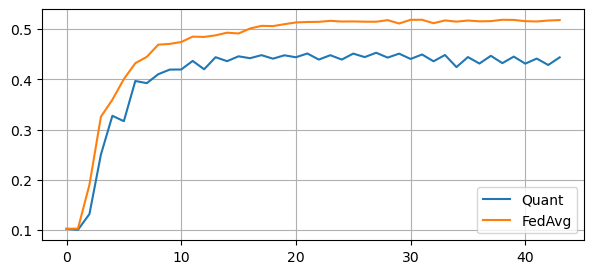

In [41]:
acc_q_temp = np.array(global_acc_list) # K40, b4, L5, Lambda 0.4
acc_fed_temp = np.array(global_acc_list_FedAvg)
acc_q1 = acc_q_temp[0:44]
acc_fed1 = acc_fed_temp[0:44]
plt.figure(figsize=(7, 3)) # K40, b4, L3, Lambda 0.05
plt.plot(acc_q1) 
acc_fed011 = acc_fed01
plt.plot(acc_fed1)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')

print(np.mean(percentage[:,0:44]))
print(np.mean((32+Bits[:,0:44])/462410))

In [1]:
import numpy as np
import numpy.matlib
import pickle
import matplotlib.pyplot as plt
import scipy.linalg as sl
import time
import pathlib
import nbimporter  # I installed it for importing an .ipynb file into another .ipynb like the pilot_assignemnt

import pilot_assignment
import APLocation_Generation
import functionRlocalscattering
#------------------------------
#import Power_optimizers

import os

from datetime import datetime

from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import numpy.linalg as l 


import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
import time
import numpy.linalg as nl 


import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as Kr
from tensorflow.keras import initializers

import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score


from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


from __future__ import print_function
import keras
import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras import initializers

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils 

import time

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import mnist

C:\Users\afmb\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\afmb\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\afmb\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [42]:
#acc_q1 = np.array(global_acc_list)
#acc_fed1 = np.array(global_acc_list_FedAvg)

# Base directory where you want to save the results
base_dir = 'C:/FedASi files'

# Prompt the user to input the folder name
#run_folder_name = input("Enter the folder name for this run: ")
run_folder_name = 'Noniid_K40_L5_b4_T45_lambda0.4'
run_folder_path = os.path.join(base_dir, run_folder_name)

# Create the directory if it doesn't exist
os.makedirs(run_folder_path, exist_ok=True)

# List of matrices to save and their respective filenames
matrices = {
    'A_bar': A_bar,
    'B_bar': B_bar,
    'Bits' : Bits[:,0:44],
    'percentage': percentage[:,0:44],
    'I_M': I_M,
    'B_tilde': B_tilde,
    'Lambda': Lambda,
    'acc_q' : acc_q1,
    'acc_fed': acc_fed1
    
    # Add more matrices here as needed
}

# Save each matrix to a .npy file in the specified folder
for name, matrix in matrices.items():
    file_name = os.path.join(run_folder_path, f'{name}.npy')
    np.save(file_name, matrix)
    print(f'{name} saved to {file_name}')


A_bar saved to C:/FedASi files\Noniid_K40_L5_b4_T45_lambda0.4\A_bar.npy
B_bar saved to C:/FedASi files\Noniid_K40_L5_b4_T45_lambda0.4\B_bar.npy
Bits saved to C:/FedASi files\Noniid_K40_L5_b4_T45_lambda0.4\Bits.npy
percentage saved to C:/FedASi files\Noniid_K40_L5_b4_T45_lambda0.4\percentage.npy
I_M saved to C:/FedASi files\Noniid_K40_L5_b4_T45_lambda0.4\I_M.npy
B_tilde saved to C:/FedASi files\Noniid_K40_L5_b4_T45_lambda0.4\B_tilde.npy
Lambda saved to C:/FedASi files\Noniid_K40_L5_b4_T45_lambda0.4\Lambda.npy
acc_q saved to C:/FedASi files\Noniid_K40_L5_b4_T45_lambda0.4\acc_q.npy
acc_fed saved to C:/FedASi files\Noniid_K40_L5_b4_T45_lambda0.4\acc_fed.npy


In [6]:
Bits1 = np.copy(Bits)

In [20]:
# Noniid_K40_L5_b4_T45_lambda0.4
K = 40 
Bits = []
#K = 20
# Base directory where the results are saved
base_dir0 = 'C:/FedASi files'

# Prompt the user to input the folder name
run_folder_name = input("Enter the folder name to load matrices from: ")
run_folder_path = os.path.join(base_dir0, run_folder_name)

# Check if the directory exists
if not os.path.exists(run_folder_path):
    raise FileNotFoundError(f"The directory {run_folder_path} does not exist.")

# Load all .npy files from the specified folder
for file_name in os.listdir(run_folder_path):
    if file_name.endswith('.npy'):
        matrix_name = os.path.splitext(file_name)[0]  # Extract the matrix name without extension
        file_path = os.path.join(run_folder_path, file_name)
        try:
            # Load the matrix and assign it to a variable with the name `matrix_name`
            globals()[matrix_name] = np.load(file_path, allow_pickle=True)
            print(f'{matrix_name} loaded from {file_path}')
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

# Now you can use the matrices directly
# Example:
# print(A_bar)
# print(B_bar)
# print(Bits)

#LAQ_Noniid_K40_L5_b4_T40
# Noniid_K40_L5_b4_T45_lambda0.4

Enter the folder name to load matrices from: AQUILA_Noniid_K40_L5_T40
acc_fed loaded from C:/FedASi files\AQUILA_Noniid_K40_L5_T40\acc_fed.npy
acc_q loaded from C:/FedASi files\AQUILA_Noniid_K40_L5_T40\acc_q.npy
Bits loaded from C:/FedASi files\AQUILA_Noniid_K40_L5_T40\Bits.npy


In [43]:
acc_q, acc_fed

(array([0.1021    , 0.1002    , 0.13160001, 0.25009999, 0.3274    ,
        0.31659999, 0.39669999, 0.3924    , 0.4102    , 0.41940001,
        0.41960001, 0.43669999, 0.4201    , 0.44409999, 0.43619999,
        0.44589999, 0.44209999, 0.44819999, 0.44119999, 0.4479    ,
        0.44400001, 0.4515    , 0.43939999, 0.4481    , 0.43939999,
        0.4513    , 0.4443    , 0.45300001, 0.44330001, 0.45120001,
        0.44060001, 0.44949999, 0.43599999, 0.44850001, 0.4244    ,
        0.44440001, 0.43149999, 0.44690001, 0.4323    , 0.44530001,
        0.43130001, 0.44139999, 0.42860001, 0.4438    ]),
 array([0.1021    , 0.1026    , 0.1899    , 0.32550001, 0.3594    ,
        0.4005    , 0.43220001, 0.44479999, 0.4691    , 0.47060001,
        0.47440001, 0.4851    , 0.48449999, 0.48769999, 0.493     ,
        0.4914    , 0.50129998, 0.50660002, 0.5061    , 0.50989997,
        0.51340002, 0.51429999, 0.51459998, 0.51660001, 0.51520002,
        0.51539999, 0.51490003, 0.51480001, 0.51800001, 0.

In [19]:
#Bits = 4*462410* np.ones([K,50])# 
#Bits = 7325* np.ones([K,50])
Bits = 1712073*np.ones([K,50])   #AQUILA, mean equal to 3.7025 per element
p_dink, lambda_din, F_din = find_optimal_p_generalized_Dinkelbach_CFmMIMO(a, b, I_Lk, I_pk_test1, b_k_prime, np.array([1, 1]), P_u, epsilon=1e-8)

powers = p_dink
SINR_dink = compute_SINR(max_eta_t, p_dink, A_bar, B_bar, B_tilde, I_M, 1712073*np.ones(K), K)
latencies_dink = compute_latencies(SINR_dink, 1712073*np.ones(K)/B_tau, K)

print('Latency Dink:', np.max(latencies_dink))

SINR_maxsum = compute_SINR(max_eta_t, np.ones(K), A_bar, B_bar, B_tilde, I_M, 1712073*np.ones(K), K)
latencies_maxsum = compute_latencies(SINR_maxsum, 1712073*np.ones(K)/B_tau, K)
print('latency max-sum rate:', np.max(latencies_maxsum) )

C:\Users\afmb\AppData\Local\Temp\ipykernel_4112\3229412868.py:515: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]


Latency Dink: 0.13894404460448484
latency max-sum rate: 19.36518441403217


C:\Users\afmb\AppData\Local\Temp\ipykernel_4112\3229412868.py:525: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]
C:\Users\afmb\AppData\Local\Temp\ipykernel_4112\3229412868.py:554: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]


# Power allocation

In [21]:
import numpy as np
import math
T=1
K = 40
index = 0
tau_p = min(K,10) #Orthogonal sequences if tau_p=K, else tau_p = 10

tau_c = 200
prelogFactor = (tau_c-tau_p)/(tau_c)
BW = 20e6
B_tau = BW*prelogFactor 

eps = 0.01

# Function to check feasibility of power allocations and return power values
def check_feasibility(eta_t, A_bar, B_bar, B_tilde, I_M, beta, T, K, tolerance=1e-6):
    itr = 0
    powers = (1/K)*np.ones(K)
    powers_old = 10*(1/K)*np.ones(K)
    gamma_t = 2 ** (eta_t * beta) - 1
    while np.linalg.norm(powers - powers_old) > tolerance:
        itr += 1
        powers_old = np.copy(powers)
        for j in range(K):
            numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])
            denominator = A_bar[j] - gamma_t[j] * B_bar[j]
            if denominator <= 0:
                return False, None
            powers[j] = numerator / denominator
        # Check for iteration limit
        if itr > 1000:  # to avoid infinite loop
            break
    if np.any(powers < 0) or np.any(powers > 1):
        return False, None
    return True, powers

# Function to compute SINR_t^j given powers
def compute_SINR(eta_t, powers, A_bar, B_bar, B_tilde, I_M, beta, K):
    SINR = np.zeros(K)
    #gamma_t = 2 ** (eta_t * beta ) - 1
    for j in range(K):
        interference = np.sum(powers * B_tilde[j]) + I_M[j]
        SINR[j] = A_bar[j] * powers[j] / (B_bar[j] * powers[j] + interference)
    return SINR

# Function to compute latencies ell_t^j given SINR_t^j
def compute_latencies(SINR, beta, K):
    latencies = np.zeros(K)
    for j in range(K):
        if SINR[j] > 0:
            latencies[j] = beta[j] / math.log2(1 + SINR[j])
        else:
            latencies[j] = float('inf')  # Handle cases where SINR[j] is zero
    return latencies

# Bisection method to find maximum eta_t and store power allocations
def bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta, T, K, eta_t_lower=1, eta_t_upper=30, tolerance=1e-6):
    itr_Bis = 0
    best_eta_t = eta_t_lower
    best_powers = None
    while eta_t_upper - eta_t_lower > tolerance:
        itr_Bis += 1
        eta_t_mid = (eta_t_lower + eta_t_upper) / 2.0
        feasible, powers = check_feasibility(eta_t_mid, A_bar, B_bar, B_tilde, I_M, beta, T, K)
        if feasible:
            best_eta_t = eta_t_mid
            best_powers = powers
            eta_t_lower = eta_t_mid
        else:
            eta_t_upper = eta_t_mid
    #print('Bisection iteration:', itr_Bis)
    return best_eta_t, best_powers

# Example usage-----
beta = 1*Bits/ (B_tau) 
max_eta_t, optimal_powers = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta[:,index], T, K)
if optimal_powers is None:
    print("No feasible power allocation found.")
else:
    print("Maximum eta_t:", max_eta_t)
    print("Optimal power allocations:", optimal_powers)

    # Compute SINR and latencies
    SINR_optimal = compute_SINR(max_eta_t, optimal_powers, A_bar, B_bar, B_tilde, I_M, beta[:,index], K)
    latencies_optimal = compute_latencies(SINR_optimal, beta[:,index], K)

    # Print latencies
    print("\nLatencies:")
    for j in range(K):
        print(f"User {j + 1}: {latencies_optimal[j]}")
    print(np.max(latencies_optimal))

    
 ####--- Dinkelbach:----------------------------------------

SINR_dink = compute_SINR(max_eta_t, p_dink, A_bar, B_bar, B_tilde, I_M, beta[:,index], K)
latencies_dink = compute_latencies(SINR_dink, beta[:,index], K)


C:\Users\afmb\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\afmb\AppData\Local\Temp\ipykernel_4112\1875589473.py:25: RuntimeWarning: invalid value encountered in multiply
  numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])


Maximum eta_t: 10.26373341679573
Optimal power allocations: [1.05101058e-01 2.57822156e-01 3.71295739e-01 9.99954105e-01
 1.39701775e-01 8.96719881e-02 4.76748669e-03 1.68461359e-02
 2.30084385e-02 2.67488096e-01 1.02862551e-01 1.12664667e-02
 4.68136237e-03 8.26184837e-04 4.61391864e-03 1.49274490e-01
 2.52695972e-01 3.02538763e-01 1.58018060e-03 5.01733344e-04
 5.32064268e-04 5.41710246e-02 7.74241876e-03 1.20519366e-01
 2.00538842e-01 3.00652954e-01 1.10151490e-01 2.35785524e-02
 4.13487550e-04 1.20817781e-02 6.31933404e-03 2.76871719e-01
 5.22169051e-02 2.79846587e-01 5.42427286e-03 4.22330329e-01
 2.61697689e-03 2.19765746e-01 5.51606517e-02 8.86831636e-02]

Latencies:
User 1: 0.09730455152157405
User 2: 0.09730586554976237
User 3: 0.0972994820500439
User 4: 0.09731049506265964
User 5: 0.09735104628189682
User 6: 0.09732118810592291
User 7: 0.09736817180428997
User 8: 0.09732275806132833
User 9: 0.09732315208593512
User 10: 0.09734439023120371
User 11: 0.09733439296374234
User 12:

In [52]:
SINR_dink = compute_SINR(max_eta_t, p_dink, A_bar, B_bar, B_tilde, I_M, 463220*np.ones(K), K)
latencies_dink = compute_latencies(SINR_dink, beta[:,index], K)
print('latency dinkelbach:', np.max(latencies_dink) )


SINR_maxsum = compute_SINR(max_eta_t, np.ones(K), A_bar, B_bar, B_tilde, I_M, 463220*np.ones(K), K)
latencies_maxsum = compute_latencies(SINR_maxsum, beta[:,index], K)
print('latency max-sum rate:', np.max(latencies_maxsum) )

latency dinkelbach: 693.5120460098174
latency max-sum rate: 4.405078619778184


In [23]:
num_global_iterations = 40
iteration_latency = np.ones(num_global_iterations)
for k in range(num_global_iterations):
    index = k
    print('---------------------------------------------------------')
    print('iteration:', k)
    max_eta_t, optimal_powers = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta[:,index], T, K)
    if optimal_powers is None:
        print("No feasible power allocation found.")
    else:
        print("Maximum eta_t:", max_eta_t)
       # print("Optimal power allocations:", optimal_powers)

        # Compute SINR and latencies
        SINR_optimal = compute_SINR(max_eta_t, optimal_powers, A_bar, B_bar, B_tilde, I_M, beta[:,index], K)
        latencies_optimal = compute_latencies(SINR_optimal, beta[:,index], K)

        # Print latencies
        #print("\nLatencies:")
        #for j in range(K):
            #print(f"User {j + 1}: {latencies_optimal[j]}")
        print('max latency:', np.max(latencies_optimal), 'at iteration:', k)
        iteration_latency[k] = np.max(latencies_optimal)
    
    
    
    
    


---------------------------------------------------------
iteration: 0


C:\Users\afmb\AppData\Local\Temp\ipykernel_4112\1875589473.py:25: RuntimeWarning: invalid value encountered in multiply
  numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])


Maximum eta_t: 10.26373341679573
max latency: 0.09743043387736323 at iteration: 0
---------------------------------------------------------
iteration: 1
Maximum eta_t: 13.70706182718277
max latency: 0.07295509516247155 at iteration: 1
---------------------------------------------------------
iteration: 2


C:\Users\afmb\AppData\Local\Temp\ipykernel_4112\1875589473.py:25: RuntimeWarning: overflow encountered in multiply
  numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])


Maximum eta_t: 11.385726153850555
max latency: 0.08782926854971027 at iteration: 2
---------------------------------------------------------
iteration: 3
Maximum eta_t: 10.871653020381927
max latency: 0.09198233222907527 at iteration: 3
---------------------------------------------------------
iteration: 4
Maximum eta_t: 10.462728381156921
max latency: 0.0955773641033224 at iteration: 4
---------------------------------------------------------
iteration: 5
Maximum eta_t: 9.324191838502884
max latency: 0.10724790065672467 at iteration: 5
---------------------------------------------------------
iteration: 6
Maximum eta_t: 8.654154747724533
max latency: 0.1155514350217661 at iteration: 6
---------------------------------------------------------
iteration: 7
Maximum eta_t: 8.247344106435776
max latency: 0.12125115517123322 at iteration: 7
---------------------------------------------------------
iteration: 8
Maximum eta_t: 8.249979257583618
max latency: 0.12121242596831634 at iteration: 8

IndexError: index 39 is out of bounds for axis 1 with size 39

In [31]:
#AQUILA_ Dink
total_lat=np.zeros(39)
for i in range(39):
    total_lat[i] = (i+1)*1*(0.075 + 0.139)
total_lat

array([0.214, 0.428, 0.642, 0.856, 1.07 , 1.284, 1.498, 1.712, 1.926,
       2.14 , 2.354, 2.568, 2.782, 2.996, 3.21 , 3.424, 3.638, 3.852,
       4.066, 4.28 , 4.494, 4.708, 4.922, 5.136, 5.35 , 5.564, 5.778,
       5.992, 6.206, 6.42 , 6.634, 6.848, 7.062, 7.276, 7.49 , 7.704,
       7.918, 8.132, 8.346])

In [30]:
#AQUILA_ my approach
total_lat=np.zeros(39)
for i in range(39):
    total_lat[i] = (i+1)*1*0.075 + np.sum(iteration_latency[0:i])
total_lat    

array([0.075     , 0.24743043, 0.39538553, 0.5582148 , 0.72519713,
       0.89577449, 1.07802239, 1.26857383, 1.46482498, 1.66103741,
       1.85928187, 2.06118407, 2.25830135, 2.46025752, 2.6572886 ,
       2.85478003, 3.05148642, 3.24891609, 3.44608604, 3.63912601,
       3.83099509, 4.02749342, 4.21445946, 4.40558528, 4.59712914,
       4.78342481, 4.97333019, 5.16325402, 5.35894246, 5.54153357,
       5.73315607, 5.91868938, 6.10799299, 6.2979669 , 6.48385766,
       6.67308002, 6.8557253 , 7.0380348 , 7.22432865])

# FL For two lambdas:

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data

# Define neural network architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
# Define the number of clients and local epochs
num_clients= K
#local_epochs = 1
local_epochs0 = 3 #local_epochs FedAvg
local_epochs = 3
epoch_increase = 0
b_j= 4

# Federated Averaging algorithm
num_global_iterations = 30
k_0 = -100 #num_global_iterations +1

#learning_rate = 1e-3
#optimizer = SGD(learning_rate=learning_rate)
optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)

#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4) #


# Split the data into non-overlapping portions for each client
client_data = []
samples_per_client = len(x_train) // num_clients
for i in range(num_clients):
    start = i * samples_per_client
    end = (i + 1) * samples_per_client
    x_client = x_train[start:end]
    y_client = y_train[start:end]
    client_data.append((x_client, y_client))

    
    

# Initialize the global model
global_model = create_model()
global_model1 = create_model()
global_model31 = create_model()

# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


global_model1.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

global_model31.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


#global_model_FedAvg = global_model 
global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
global_weights1 = global_model.get_weights()
global_weights31 = global_model.get_weights()
B_q = np.zeros([8,num_global_iterations])

#------------- FedAvg benchmark----------------------


global_model_FedAvg.set_weights(global_weights1)
global_acc_list1 = []
global_loss_list1 = []

global_acc_list31 = []
global_loss_list31 = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list1.append(initial_accuracy)
global_acc_list31.append(initial_accuracy)

#----------------------------------------------------------------------------------------------------------
Bits1 = np.zeros([num_clients, num_global_iterations])
Bits31 = np.zeros([num_clients, num_global_iterations])

percentage1 = np.zeros([num_clients, num_global_iterations])
percentage31 = np.zeros([num_clients, num_global_iterations])

N_total1 = 0
N_total31 = 0
t_start = time.time()
#-----------------------------------------------------
for k in range(num_global_iterations):
    print(f"Global Iteration {k + 1}/{num_global_iterations}")
    

    # List to store client models for averaging
    client_models1 = []
    client_models31 = []
    client_models_FedAvg = []

    for i in range(num_clients):
        N_total1 = 0
        N_total31 = 0
        print(f"Client {i + 1}/{num_clients}")
        x_local, y_local = client_data[i]

        # Create a copy of the global model for each client
        local_model1 = create_model()
        local_model1.set_weights(global_weights1)#global_model.get_weights())
        
        local_model31 = create_model()
        local_model31.set_weights(global_weights31)
        #----------------------- FedAvg benchmark--------------------------------
        local_model_FedAvg = create_model()
        local_model_FedAvg.set_weights(global_model_FedAvg.get_weights())
        local_model_FedAvg .compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        local_model_FedAvg .fit(x_local, y_local, epochs=local_epochs0, verbose=0)
        
            
        #----------------------------------------------------
        # Compile and train the local model
        local_model1.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model1.fit(x_local, y_local, epochs=local_epochs , verbose=0)

        local_model31.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model31.fit(x_local, y_local, epochs=local_epochs , verbose=0)
#--------------------------------------------------- Quantization -----------------------------------------
        if k>k_0:
        # Quantize the local model weights
        #quantized_weights = [np.round(w * 127) / 127 for w in local_model.get_weights()]
            diff_local_global_weight1 = np.array(local_model1.get_weights())-np.array(global_weights1)
            diff_local_global_weight31 = np.array(local_model31.get_weights())-np.array(global_weights31)
            
            local_weight_shape_0 = diff_local_global_weight1.shape[0]
            quantized_diff_local_global_weight1 = diff_local_global_weight1
            quantized_diff_local_global_weight31 = diff_local_global_weight31
            
            err = np.zeros([local_weight_shape_0 ,1])
            b_p = np.zeros([local_weight_shape_0 ,1])
            b_q =  np.zeros([local_weight_shape_0 ,1])
            x_previous = np.zeros([local_weight_shape_0 ,1])
            x_all_original = np.zeros([local_weight_shape_0 ,1])
            p10 = 0
            x_all = 0
            x = np.zeros([local_weight_shape_0,1])
            
            Quantized_diff_local_global_weight1 = []
            Quantized_diff_local_global_weight31 = []
            
            for h in range(local_weight_shape_0):
                x_position = 0
                if h==0:
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(27*32,)
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(27*32,)
                    #Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
               ## quantized_diff_local_global_weight[h], tau, err[h], r = Quantization_NNs(bits,R,diff_local_global_weight[h])
                if h==2:
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(7200*64,)
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(7200*64,)
                
                if h in (1, 3, 5):
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(quantized_diff_local_global_weight1[h].shape[0],)
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(quantized_diff_local_global_weight31[h].shape[0],)

                #if h==6:
                   # quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,1)
                    
                if h==4:
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(10*64,)
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(10*64,)
                
#-------------Here, I evaluate the choices for Lambda--------------------------------------------------------
            
            for h in range(local_weight_shape_0):
                Quantized_diff_local_global_weight1 = np.concatenate((Quantized_diff_local_global_weight1,quantized_diff_local_global_weight1[h]))
                Quantized_diff_local_global_weight31 = np.concatenate((Quantized_diff_local_global_weight31,quantized_diff_local_global_weight31[h]))
           
            
            #Quantized_diff_local_global_weight_for_me = Quantized_diff_local_global_weight
            
           
        # print('min:',np.min(Quantized_diff_local_global_weight))
        
            #nmax = 10000#min(2000*(2+k), 50000)
            #nmin = nmax
           # print( 'min of absolute value:',np.min(np.abs(Quantized_diff_local_global_weight)))
            #Quantized_diff_local_global_weight, max_model, min_model, err = adaptive_signQuant(Quantized_diff_local_global_weight, Quantized_diff_local_global_weight.shape[0], nmax,nmin)
            
            Quantized_diff_local_global_weight1, max_model1, min_model1, err1, n_max1, n_min1, x_min_me1= adaptive_signQuant_lambda(Quantized_diff_local_global_weight1, 
                                                                                                       Quantized_diff_local_global_weight1.shape[0], Lambda1[i],b_j)
            
            Bits1[i,k] = (462410 - n_max1 - n_min1) + b_j*(n_max1 + n_min1)
            #Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
            print('%----- Lambda1-------------------------------------')
            print('max:',np.max(Quantized_diff_local_global_weight1), '----min:',np.min(Quantized_diff_local_global_weight1))
            print('max error1:', np.max(np.abs(err1)))# - np.sum(Quantized_diff_local_global_weight1))
            #print('sum 1r:', np.sum(Quantized_diff_local_global_weight1))
            #print('max_model:', max_model)
            #print('min_model:', min_model)
            print('max_model1:', max_model1, 'min_model:', min_model1, 'x_min_me1:', x_min_me1)
            print('n_max1:', n_max1, 'n_min1:', n_min1, 'Lambda_j1:', Lambda1[i])
            N_total1 += n_max1 + n_min1
            percentage1[i,k]  = 100*(n_min1+n_max1)/462410
            print('percentage1 %:', percentage1[i,k] )
            
            print('%----- Lambda31-------------------------------------')
            Quantized_diff_local_global_weight31, max_model31, min_model31, err31, n_max31, n_min31, x_min_me31 = adaptive_signQuant_lambda(Quantized_diff_local_global_weight31, 
                                                                                                       Quantized_diff_local_global_weight31.shape[0], Lambda31[i],b_j)
            
            Bits31[i,k] = (462410 - n_max31 - n_min31) + b_j*(n_max31 + n_min31)
            #Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
            print('max:',np.max(Quantized_diff_local_global_weight31), '----min:',np.min(Quantized_diff_local_global_weight31))
            print('max error31:', np.max(np.abs(err31)))# - np.sum(Quantized_diff_local_global_weight1))
            #print('sum 1r:', np.sum(Quantized_diff_local_global_weight1))
            #print('max_model:', max_model)
            #print('min_model:', min_model)
            print('max_model31:', max_model31, 'min_model31:', min_model31, 'x_min_me1:', x_min_me31)
            print('n_max31:', n_max31, 'n_min31:', n_min31, 'Lambda_j31:', Lambda31[i])
            N_total31 += n_max31 + n_min31
            percentage31[i,k]  = 100*(n_min31+n_max31)/462410
            print('percentage31 %:', percentage31[i,k] )
            #------------------ Update the local model with quantized weights:-----------------------------
            dim_h = 0
            for h in range(local_weight_shape_0):
                if h==0:
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[0:27*32]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(3, 3, 3, 32)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[0:27*32]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(3, 3, 3, 32)
                    dim_h += 27*32
                    
                    
                if h==1:
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[dim_h: dim_h+32]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(32,)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[dim_h: dim_h+32]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(32,)
                    dim_h += 32
                if h==2: 
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[dim_h: dim_h+7200*64]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(7200, 64)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[dim_h: dim_h+7200*64]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(7200, 64)
                    dim_h+= 7200*64
                if h==3:
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[dim_h: dim_h+64]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(64,)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[dim_h: dim_h+64]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(64,)
                    dim_h += 64
            
                #if h==6:
                 #   quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    
                if h==4:
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[dim_h: dim_h+640]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(64,10)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[dim_h: dim_h+640]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(64,10)
                    dim_h += 640
              
                if h==5:
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[dim_h: dim_h+10]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(10,)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[dim_h: dim_h+10]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(10,)
                    dim_h += 10
            
            
            local_model1.set_weights(quantized_diff_local_global_weight1 + np.array(global_weights1))
            local_model31.set_weights(quantized_diff_local_global_weight31 + np.array(global_weights31))
        #else:
           # local_model.set_weights()
            
        # Add the trained and quantized local model to the list
        client_models1.append(local_model1)
        client_models31.append(local_model31)
        client_models_FedAvg.append(local_model_FedAvg)
        #B_q[:,k] += b_q
            
        #---------------------------FedAvg benchmark---------------------------------
    #print('nmax:', nmax)
    global_weights_FedAvg = np.mean([model.get_weights() for model in client_models_FedAvg], axis=0)
    global_model_FedAvg.set_weights(global_weights_FedAvg)

#------------------------------------------------------------------------------------------------------------
    # Calculate the global model's new weights as the average of the client models
    if k <= k_0:
        global_model.set_weights(global_weights_FedAvg)
        global_weights = global_weights_FedAvg
    else:
        global_weights1 = np.mean([model.get_weights() for model in client_models1], axis=0)
        global_model1.set_weights(global_weights1)
        
        global_weights31 = np.mean([model.get_weights() for model in client_models31], axis=0)
        global_model31.set_weights(global_weights31)
        #local_epochs = min(12, local_epochs + epoch_increase)
        #local_epochs += epoch_increase
        #local_epochs0 = local_epochs
        #local_epochs = max(1, local_epochs)
    
    if k == k_0:
        local_epochs += epoch_increase
        local_epochs0 = local_epochs
   # B_q[:,k] = b_q
#----------------------------------------------------------------------------
    # Evaluate the global model on the test data
    print('----------------------------For Lambda1-----------------------------------------------------')
    
    loss1, accuracy1 = global_model1.evaluate(x_test, y_test)
    print(f"Global Test loss1: {loss1:.4f}, Global Test accuracy1: {accuracy1:.4f}")
    global_acc_list1.append(accuracy1)
    global_loss_list1.append(loss1)
    
    print('----------------------------For Lambda31-----------------------------------------------------')
    
    loss31, accuracy31 = global_model31.evaluate(x_test, y_test)
    print(f"Global Test loss31: {loss31:.4f}, Global Test accuracy31: {accuracy31:.4f}")
    global_acc_list31.append(accuracy31)
    global_loss_list31.append(loss31)
   # print('Lambda:',Lambda)
# The final global model is stored in 'global_model'
#-------------------------------------Evaluate the FedAvg global model on the test data----------------------
    print('------------------------------ ------FedAvg Benchmark------------------------------------------------')
    loss_FedAvg, accuracy_FedAvg = global_model_FedAvg.evaluate(x_test, y_test)
    print(f"_FedAvg Global Test loss: {loss_FedAvg:.4f}, _FedAvg Global Test accuracy: {accuracy_FedAvg:.4f}")
    print('------------------------------------------------------------------------------------------------------')
    global_acc_list_FedAvg.append(accuracy_FedAvg)
    global_loss_list_FedAvg.append(loss_FedAvg)
    #----------------
   # plt.figure(figsize=(7, 3))
   # plt.plot(global_acc_list)    
   # plt.plot(global_acc_list_FedAvg)
   # plt.legend(['Quant', 'FedAvg'])
   # plt.grid(True, which='major')   
    
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list1)  
plt.plot(global_acc_list31)  
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant1','Quant31', 'FedAvg'])
plt.grid(True, which='major')    
t_stop = time.time()            
print('time:', t_stop - t_start)            
            
            

